In [1]:
import numpy as np  # 引入numpy、pandas库
import pandas as pd
from dbfread import DBF
from pandas import DataFrame
import matplotlib.pyplot as plt
import proplot as plot
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from IPython.display import display
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 刻度格式
import matplotlib.ticker as mticker  # 添加网格线
import math
from matplotlib import patches

pd.options.display.max_columns = None


In [3]:
path = "./data/IBTrACS.since1980.list.v04r00.lines.dbf"
df_raw = pd.DataFrame(iter(DBF(path)))

In [4]:
df = df_raw[(df_raw['USA_STATUS'] != "EX") 
            & (df_raw['USA_STATUS'] != "SS") 
            & (df_raw['USA_STATUS'] != "PT") 
            & (df_raw['USA_STATUS'] != "IN")
            & (df_raw['USA_STATUS'] != "DS") 
            & (df_raw['USA_STATUS'] != "WV")
            & (df_raw['USA_STATUS'] != "ET") 
            & (df_raw['USA_STATUS'] != "MD") 
            & (df_raw['USA_STATUS'] != "XX")
            & (df_raw['USA_STATUS'] != "LO")]# 去掉表格属性USA_STATUS为EX的数据

In [5]:
def filter_indesity(df_, year, indensity):
    """
    df:
    int year: year
    indensity: 台风大小
    return 返回满足年份year台风大小大于34的台风编号列表 以及最小台风大小
    """
    df_year = df_[df_['year'] == year]
    Typh_times = df_year['NUMBER'].value_counts().sort_index().reset_index() # 每个台风出现的次数
    Typh_times.rename(columns={'NUMBER': 'times'})
    ls_num_indensity = []
    ls_min = []
    ls_max = []
    for typh_num in Typh_times['index']:
        df_typh_num = df_year[df_year['NUMBER'] == typh_num]
        typh_num_max = df_typh_num['USA_WIND'].max()
    #     print("The No. %d maxium is %.2f" %(typh_num, typh_num_max))
        if math.isnan(typh_num_max) is False:
            if typh_num_max > indensity:
                ls_wind_indesity = list(df_typh_num['USA_WIND'])
                length_indesity = len(ls_wind_indesity)
                typh_num_min = df_typh_num['USA_WIND'].min()
                df_indesity_min = df_typh_num[df_typh_num['USA_WIND'] == typh_num_min]
                min_times = df_indesity_min['USA_WIND'].value_counts()
                min_times = min_times[int(typh_num_min)]
                ls_num_indensity.append(typh_num)
                ls_min.append(typh_num_min) 
                ls_max.append(typh_num_max)

    return ls_num_indensity, ls_min, ls_max


In [6]:
def filter_min_and_max(df_, year, num):
    """
    int TpyhoneNomber:  num
    return 返回当前year年份的编号为num的最小台风数据和最大台风数据 dataframe
    """
    df_year = df_[df_['year'] == year]
    df_typh_num = df_year[df_year['NUMBER'] == num]
    typh_num_max = df_typh_num['USA_WIND'].max() # 查找最大值
#     print("The No. %d maxium is %.2f" %(typh_num, typh_num_max))

    ls_wind_indesity = list(df_typh_num['USA_WIND']) #列出台风风速的列表
    # length_indesity = len(ls_wind_indesity)  # 求长度
    typh_num_min = df_typh_num['USA_WIND'].min() # 找出最小台风风速

    df_indesity_min = df_typh_num[df_typh_num['USA_WIND'] == typh_num_min] # 设置最小台风风速的dataframe结构
    # min_counts = df_indesity_min['USA_WIND'].value_counts() #计算最小值出现了多少次
    # min_counts[int(typh_num_min)]
    # df_indesity_min[:1]

    df_indesity_max = df_typh_num[df_typh_num['USA_WIND'] == typh_num_max] # 设置最大台风风速的dataframe结构
    return df_indesity_min, df_indesity_max

In [7]:
def lat_and_lon_usa_wind_speed(df_, year_list):
    """
    year_list: einino, lanina, neutrual
    返回风速最小值和最大值表格
    """
    df_wind_speed_min = pd.DataFrame(columns=["SEASON", "NUMBER", "LAT", "LON", "USA_WIND"])
    df_wind_speed_max = pd.DataFrame(columns=["SEASON", "NUMBER", "LAT", "LON", "USA_WIND"])

    for year in year_list:
        ls_num_indensity_year, ls_min_year, ls_max_year = filter_indesity(df_, year, 64)
        for number, min_typh in zip(ls_num_indensity_year, ls_min_year):
            df_indesity_min, df_indesity_max = filter_min_and_max(df_, year, number)
            df_wind_speed_min = df_wind_speed_min.append(df_indesity_min[0:1].loc[df_indesity_min['USA_WIND'] == min_typh, ["SEASON", "NUMBER", "LAT", "LON", "USA_WIND"]], ignore_index=True)
        for number, max_typh in zip(ls_num_indensity_year, ls_max_year):
            df_indesity_min, df_indesity_max = filter_min_and_max(df_, year, number)
            df_wind_speed_max = df_wind_speed_max.append(df_indesity_max[0:1].loc[df_indesity_max['USA_WIND'] == max_typh, ["SEASON", "NUMBER", "LAT", "LON", "USA_WIND"]], ignore_index=True)
        
    return df_wind_speed_min, df_wind_speed_max

In [8]:
df_basin = df['BASIN'].value_counts().sort_index().reset_index()

df_basin['index'][0]

'EP'

In [9]:
def lon_lat_min(df_, df_wind_speed, year_list):
    df_lat = df_.sort_values(by = ['LAT']).reset_index()
    # LON列里面的值大于180的value，用value-360代替
    df_wind_speed['LON'] = df_['LON'].mask(df_['LON'] > 180, 
                                                                       (df_['LON'] - 360))
    df_lon = df_.sort_values(by = ['LON']).reset_index()
    """
    找出（25%, 75%)纬度范围(low_point_lat, up_point_lat)
    """
    low_line_lat = int(df_lat.shape[0] / 4)
    up_line_lat = int(df_lat.shape[0] * 3 / 4)
    low_point_lat = df_lat.iloc[low_line_lat-1]['LAT']
    up_point_lat = df_lat.iloc[up_line_lat]['LAT']
    print("纬度最小值为%.2f，最大值为%.2f"%(low_point_lat, up_point_lat))
    """
    找出（25%, 75%)经度范围(low_point_lon, up_point_lon)
    """
    low_line_lon = int(df_lon.shape[0] / 4)
    up_line_lon = int(df_lon.shape[0] * 3 / 4)
    low_point_lon = df_lon.iloc[low_line_lon-1]['LON']
    up_point_lon = df_lon.iloc[up_line_lon]['LON']
    print("经度最小值为%.2f，最大值为%.2f"%(low_point_lon, up_point_lon))
    scale_lat = up_point_lat - low_point_lat
    scale_lon = up_point_lon - low_point_lon
    print("纬度最大差值为%.2f，经度最大差值为%.2f"%(scale_lat, scale_lon))
    return low_point_lon, low_point_lat, scale_lon, scale_lat


===开始计算einino最小风速经纬度===
纬度最小值为7.20，最大值为29.13
经度最小值为-177.80，最大值为-90.10
纬度中间值为18.16，经度中间值为-133.95
===开始计算einino最大风速经纬度===
纬度最小值为10.07，最大值为25.30
经度最小值为-179.88，最大值为-94.50
纬度中间值为17.69，经度中间值为-137.19


NameError: name 'centre_lon' is not defined

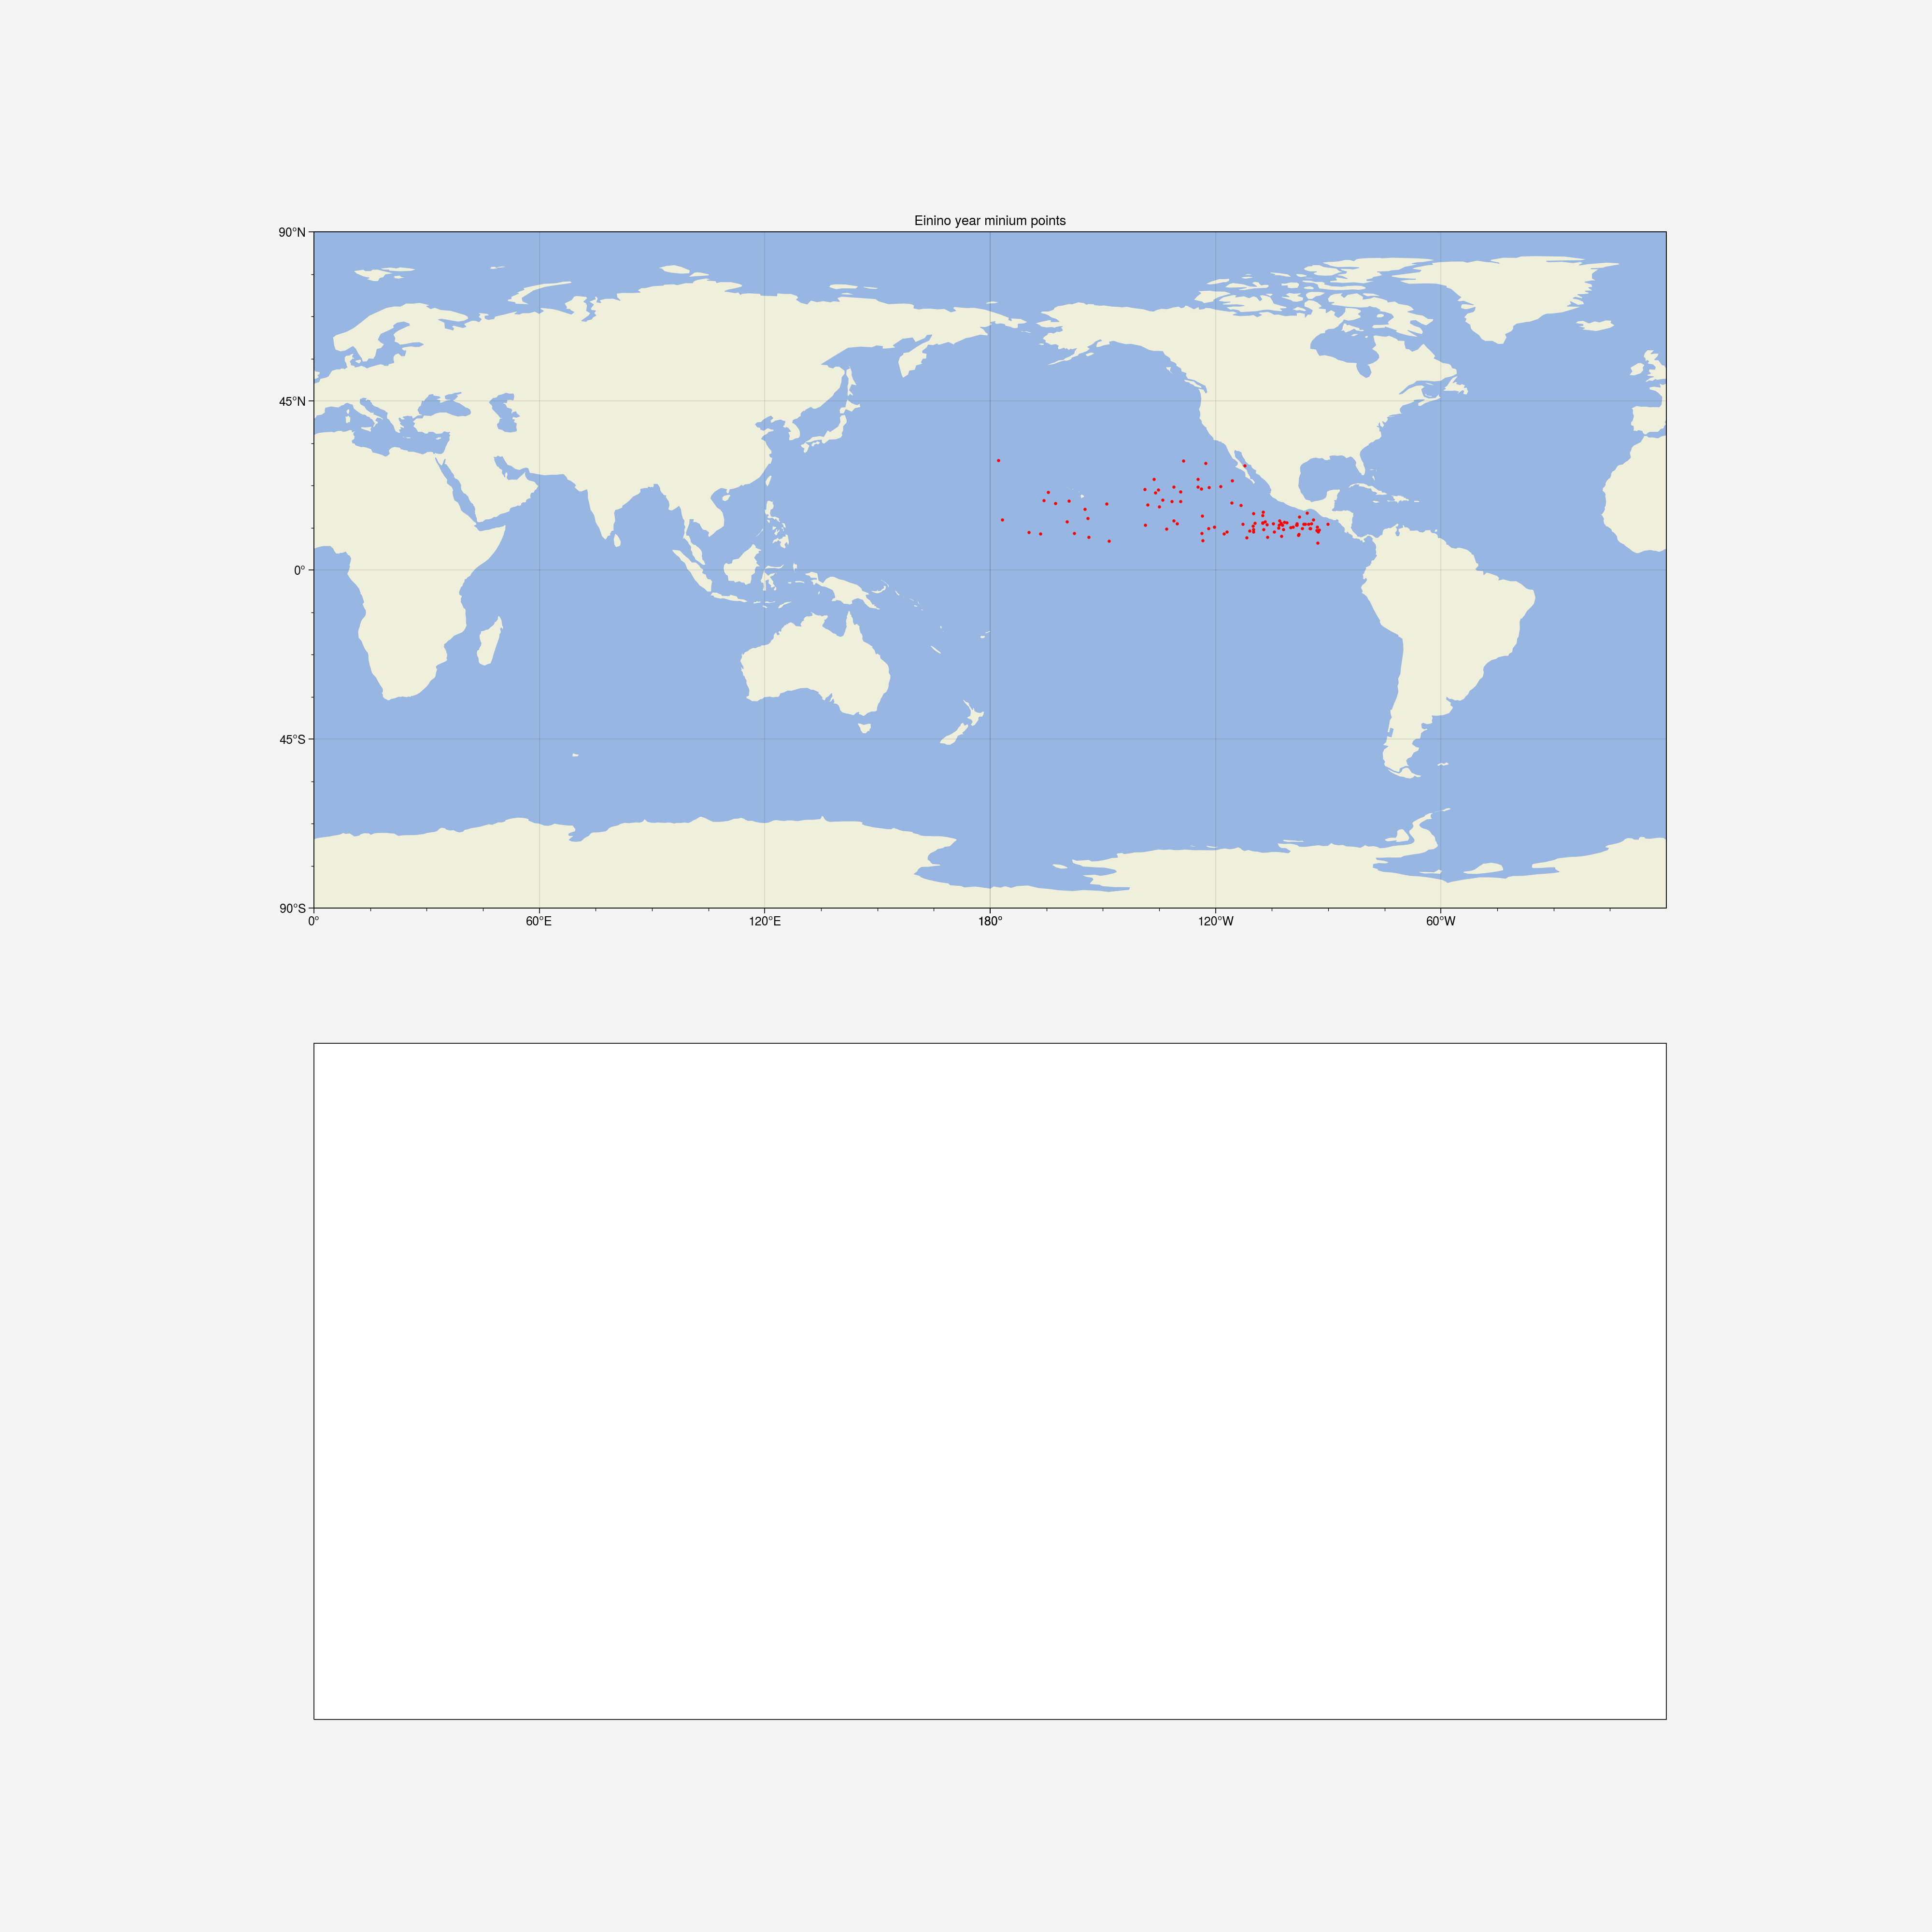

In [10]:
einino = [1982,1986,1987,1991,1994,1997,2002,2004,2009,2015]
# einino = [1986,1987,1991,1994,1997,2002,2004,2009,2015]
lanina = [1988, 1995, 1998, 1998, 2000, 2007, 2010, 2011, 2016, 2020, 2021]
neutrual = [1983, 1984, 1985, 1989, 1990, 1992, 1993, 1995, 1996, 2001, 2003, 2005, 2006, 2008, 2012, 2013, 2014, 2017, 2018, 2019]

# basin 在ep这一区的洋 
df_ep = df[df['BASIN'] == 'EP']

# 厄尔尼诺风速最大值最小值经纬度列表 
df_einino_wind_speed_min, df_einino_wind_speed_max= lat_and_lon_usa_wind_speed(df_ep, einino)


print("===开始计算einino最小风速经纬度===")
df_lat_MIN = df_einino_wind_speed_min.sort_values(by = ['LAT']).reset_index()
# LON列里面的值大于180的value，用value-360代替
df_lon_MIN = df_einino_wind_speed_min.sort_values(by = ['LON']).reset_index()

df_lon_MIN['LON'] = df_lon_MIN['LON'].mask(df_lon_MIN['LON'] > 180, (df_lon_MIN['LON'] - 360))

df_lon_MIN = df_lon_MIN.sort_values(by = ['LON']).reset_index()
"""
找出（25%, 75%)纬度范围(low_point_lat_MIN, up_point_lat_MIN)
"""
# low_line_lat_MIN = int(df_lat_MIN.shape[0] / 4)
# up_line_lat_MIN = int(df_lat_MIN.shape[0] * 3 / 4)
# low_point_lat_MIN = df_lat_MIN.iloc[low_line_lat_MIN-1]['LAT']
# up_point_lat_MIN = df_lat_MIN.iloc[up_line_lat_MIN]['LAT']

low_point_lat_MIN = df_lat_MIN["LAT"][0]
up_point_lat_MIN = df_lat_MIN['LAT'][df_lat_MIN.shape[0] - 1]
print("纬度最小值为%.2f，最大值为%.2f"%(low_point_lat_MIN, up_point_lat_MIN))
"""
找出（25%, 75%)经度范围(low_point_lon_MIN, up_point_lon_MIN)
"""
# low_line_lon_MIN = int(df_lon_MIN.shape[0] / 4)
# up_line_lon_MIN = int(df_lon_MIN.shape[0] * 3 / 4)
# low_point_lon_MIN = df_lon_MIN.iloc[low_line_lon_MIN-1]['LON']
# up_point_lon_MIN = df_lon_MIN.iloc[up_line_lon_MIN]['LON']

low_point_lon_MIN = df_lon_MIN["LON"][0]
up_point_lon_MIN = df_lon_MIN["LON"][df_lon_MIN.shape[0] - 1]
print("经度最小值为%.2f，最大值为%.2f"%(low_point_lon_MIN, up_point_lon_MIN))
centre_lat_MIN = (up_point_lat_MIN + low_point_lat_MIN) / 2
centre_lon_MIN = (up_point_lon_MIN + low_point_lon_MIN) / 2
print("纬度中间值为%.2f，经度中间值为%.2f"%(centre_lat_MIN, centre_lon_MIN))

print("===开始计算einino最大风速经纬度===")
df_lat_MAX = df_einino_wind_speed_max.sort_values(by = ['LAT']).reset_index()
# LON列里面的值大于180的value，用value-360代替
df_lon_MAX = df_einino_wind_speed_max.sort_values(by = ['LON']).reset_index()

df_lon_MAX['LON'] = df_lon_MAX['LON'].mask(df_lon_MAX['LON'] > 180, (df_lon_MAX['LON'] - 360))

df_lon_MAX = df_lon_MAX.sort_values(by = ['LON']).reset_index()
"""
找出（25%, 75%)纬度范围(low_point_lat_MAX, up_point_lat_MAX)
"""
# low_line_lat_MAX = int(df_lat_MAX.shape[0] / 4)
# up_line_lat_MAX = int(df_lat_MAX.shape[0] * 3 / 4)
# low_point_lat_MAX = df_lat_MAX.iloc[low_line_lat_MAX-1]['LAT']
# up_point_lat_MAX = df_lat_MAX.iloc[up_line_lat_MAX]['LAT']

low_point_lat_MAX = df_lat_MAX["LAT"][0]
up_point_lat_MAX = df_lat_MAX['LAT'][df_lat_MAX.shape[0] - 1]
print("纬度最小值为%.2f，最大值为%.2f"%(low_point_lat_MAX, up_point_lat_MAX))
"""
找出（25%, 75%)经度范围(low_point_lon_MAX, up_point_lon_MAX)
"""
# low_line_lon_MAX = int(df_lon_MAX.shape[0] / 4)
# up_line_lon_MAX = int(df_lon_MAX.shape[0] * 3 / 4)
# low_point_lon_MAX = df_lon_MAX.iloc[low_line_lon_MAX-1]['LON']
# up_point_lon_MAX = df_lon_MAX.iloc[up_line_lon_MAX]['LON']

low_point_lon_MAX = df_lon_MAX["LON"][0]
up_point_lon_MAX = df_lon_MAX["LON"][df_lon_MAX.shape[0] - 1]
print("经度最小值为%.2f，最大值为%.2f"%(low_point_lon_MAX, up_point_lon_MAX))
centre_lat_MAX = (up_point_lat_MAX + low_point_lat_MAX) / 2
centre_lon_MAX = (up_point_lon_MAX + low_point_lon_MAX) / 2
print("纬度中间值为%.2f，经度中间值为%.2f"%(centre_lat_MAX, centre_lon_MAX))

map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(20, 20),
    subplot_kw={'projection': map_proj}
)

ax =fig.add_subplot(2,1,1,projection=map_proj)
ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_title("Einino year minium points")
ax.scatter(df_einino_wind_speed_min['LON'], df_einino_wind_speed_min['LAT'],
        s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# 竖线
ax.scatter([centre_lon for _ in range(20)], np.arange(centre_lat-10, centre_lat+10, 1).tolist(), 
           s=6, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# 横线
# ax.scatter(np.arange(centre_lon-20, centre_lon+20, 1).tolist(), [centre_lat for _ in range(40)], 
#            s=6, c = 'b', marker = 'o', 
#         transform=ccrs.PlateCarree())

# 中间点
ax.scatter([centre_lon], [centre_lat], s=18, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

ax1 =fig.add_subplot(2,1,2,projection=map_proj)
ax1.set_global()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_title("Einino year maxium points")
ax1.scatter(df_einino_wind_speed_max['LON'], df_einino_wind_speed_max['LAT'],
        s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# 竖线
ax1.scatter([centre_lon_MAX for _ in range(20)], np.arange(centre_lat_MAX-10, centre_lat_MAX+10, 1).tolist(), 
           s=6, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 中间点
ax1.scatter([centre_lon_MAX], [centre_lat_MAX], s=18, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())


# fig = plt.figure(figsize=[20, 20])



In [11]:
def basin_MIN(df_year_wind_speed_min):
    print("===开始计算最小风速经纬度===")
    df_lat_MIN = df_year_wind_speed_min.sort_values(by = ['LAT']).reset_index()
    # LON列里面的值大于180的value，用value-360代替
    df_lon_MIN = df_year_wind_speed_min.sort_values(by = ['LON']).reset_index()
    df_lon_MIN['LON'] = df_lon_MIN['LON'].mask(df_lon_MIN['LON'] > 180, (df_lon_MIN['LON'] - 360))
    df_lon_MIN = df_lon_MIN.sort_values(by = ['LON']).reset_index()
    """
    找出（25%, 75%)纬度范围(low_point_lat_MIN, up_point_lat_MIN)
    """
    # low_line_lat_MIN = int(df_lat_MIN.shape[0] / 4)
    # up_line_lat_MIN = int(df_lat_MIN.shape[0] * 3 / 4)
    # low_point_lat_MIN = df_lat_MIN.iloc[low_line_lat_MIN-1]['LAT']
    # up_point_lat_MIN = df_lat_MIN.iloc[up_line_lat_MIN]['LAT']

    low_point_lat_MIN = df_lat_MIN["LAT"][0]
    up_point_lat_MIN = df_lat_MIN['LAT'][df_lat_MIN.shape[0] - 1]
    print("纬度最小值为%.2f，最大值为%.2f"%(low_point_lat_MIN, up_point_lat_MIN))
    """
    找出（25%, 75%)经度范围(low_point_lon_MIN, up_point_lon_MIN)
    """
    # low_line_lon_MIN = int(df_lon_MIN.shape[0] / 4)
    # up_line_lon_MIN = int(df_lon_MIN.shape[0] * 3 / 4)
    # low_point_lon_MIN = df_lon_MIN.iloc[low_line_lon_MIN-1]['LON']
    # up_point_lon_MIN = df_lon_MIN.iloc[up_line_lon_MIN]['LON']

    low_point_lon_MIN = df_lon_MIN["LON"][0]
    up_point_lon_MIN = df_lon_MIN["LON"][df_lon_MIN.shape[0] - 1]
    print("经度最小值为%.2f，最大值为%.2f"%(low_point_lon_MIN, up_point_lon_MIN))
    centre_lat_MIN = (up_point_lat_MIN + low_point_lat_MIN) / 2
    centre_lon_MIN = (up_point_lon_MIN + low_point_lon_MIN) / 2
    print("纬度中间值为%.2f，经度中间值为%.2f"%(centre_lat_MIN, centre_lon_MIN))
    return centre_lat_MIN, centre_lon_MIN

def basin_MAX(df_year_wind_speed_max):
    print("===开始计算einino最大风速经纬度===")
    df_lat_MAX = df_year_wind_speed_max.sort_values(by = ['LAT']).reset_index()
    # LON列里面的值大于180的value，用value-360代替
    df_lon_MAX = df_einino_wind_speed_max.sort_values(by = ['LON']).reset_index()

    df_lon_MAX['LON'] = df_lon_MAX['LON'].mask(df_lon_MAX['LON'] > 180, (df_lon_MAX['LON'] - 360))

    df_lon_MAX = df_lon_MAX.sort_values(by = ['LON']).reset_index()
    """
    找出（25%, 75%)纬度范围(low_point_lat_MAX, up_point_lat_MAX)
    """
    # low_line_lat_MAX = int(df_lat_MAX.shape[0] / 4)
    # up_line_lat_MAX = int(df_lat_MAX.shape[0] * 3 / 4)
    # low_point_lat_MAX = df_lat_MAX.iloc[low_line_lat_MAX-1]['LAT']
    # up_point_lat_MAX = df_lat_MAX.iloc[up_line_lat_MAX]['LAT']

    low_point_lat_MAX = df_lat_MAX["LAT"][0]
    up_point_lat_MAX = df_lat_MAX['LAT'][df_lat_MAX.shape[0] - 1]
    print("纬度最小值为%.2f，最大值为%.2f"%(low_point_lat_MAX, up_point_lat_MAX))
    """
    找出（25%, 75%)经度范围(low_point_lon_MAX, up_point_lon_MAX)
    """
    # low_line_lon_MAX = int(df_lon_MAX.shape[0] / 4)
    # up_line_lon_MAX = int(df_lon_MAX.shape[0] * 3 / 4)
    # low_point_lon_MAX = df_lon_MAX.iloc[low_line_lon_MAX-1]['LON']
    # up_point_lon_MAX = df_lon_MAX.iloc[up_line_lon_MAX]['LON']

    low_point_lon_MAX = df_lon_MAX["LON"][0]
    up_point_lon_MAX = df_lon_MAX["LON"][df_lon_MAX.shape[0] - 1]
    print("经度最小值为%.2f，最大值为%.2f"%(low_point_lon_MAX, up_point_lon_MAX))
    centre_lat_MAX = (up_point_lat_MAX + low_point_lat_MAX) / 2
    centre_lon_MAX = (up_point_lon_MAX + low_point_lon_MAX) / 2
    print("纬度中间值为%.2f，经度中间值为%.2f"%(centre_lat_MAX, centre_lon_MAX))
    return centre_lat_MAX, centre_lon_MAX
    
    
    

In [12]:
def basin_wind_speed(df_, basin, year_list):
    df_tmp = df_[df_['BASIN'] == basin]
    df_year_wind_speed_min, df_year_wind_speed_max = lat_and_lon_usa_wind_speed(df_tmp, year_list)
    return df_year_wind_speed_min, df_year_wind_speed_max

In [13]:
einino = [1982,1986,1987,1991,1994,1997,2002,2004,2009,2015]
lanina = [1988, 1995, 1998, 1998, 2000, 2007, 2010, 2011, 2016, 2020, 2021]
neutrual = [1983, 1984, 1985, 1989, 1990, 1992, 1993, 1995, 1996, 2001, 2003, 2005, 2006, 2008, 2012, 2013, 2014, 2017, 2018, 2019]


In [14]:
# einino_centre_lat_MIN, einino_centre_lon_MIN = basin_MIN(df_einino_wind_speed_min)

# einino_centre_lat_MAX, einino_centre_lon_MAX = basin_MAX(df_einino_wind_speed_max)
# basin = 'EP'  红色
df_einino_wind_speed_min_ep, df_einino_wind_speed_max_ep = basin_wind_speed(df, 'EP', einino)
# basin = "NA"  蓝色
df_einino_wind_speed_min_na, df_einino_wind_speed_max_na = basin_wind_speed(df, 'NA', einino)
# basin = "NI"  天蓝色
df_einino_wind_speed_min_ni, df_einino_wind_speed_max_ni = basin_wind_speed(df, 'NI', einino)
# basin = "SA"  绿色
df_einino_wind_speed_min_sa, df_einino_wind_speed_max_sa = basin_wind_speed(df, 'SA', einino)
# basin = "SI" 黑色
df_einino_wind_speed_min_si, df_einino_wind_speed_max_si = basin_wind_speed(df, 'SI', einino)
# basin = "SP" 紫色
df_einino_wind_speed_min_sp, df_einino_wind_speed_max_sp = basin_wind_speed(df, 'SP', einino)
# basin = "WP" 白色
df_einino_wind_speed_min_wp, df_einino_wind_speed_max_wp = basin_wind_speed(df, 'WP', einino)

In [102]:
df['BASIN'].value_counts().sort_index().reset_index()

,index,BASIN
0,EP,39647
1,NA,29921
2,NI,12494
3,SA,20
4,SI,56773
5,SP,27674
6,WP,93301


In [84]:
def mean_lon_lat(df_):
    df_['LON'] = df_['LON'].mask(df_['LON'] > 180, (df_['LON'] - 360))
    lon_mean = round(df_["LON"].mean(), 2)
    lat_mean = round(df_["LAT"].mean(), 2)
    return lon_mean, lat_mean

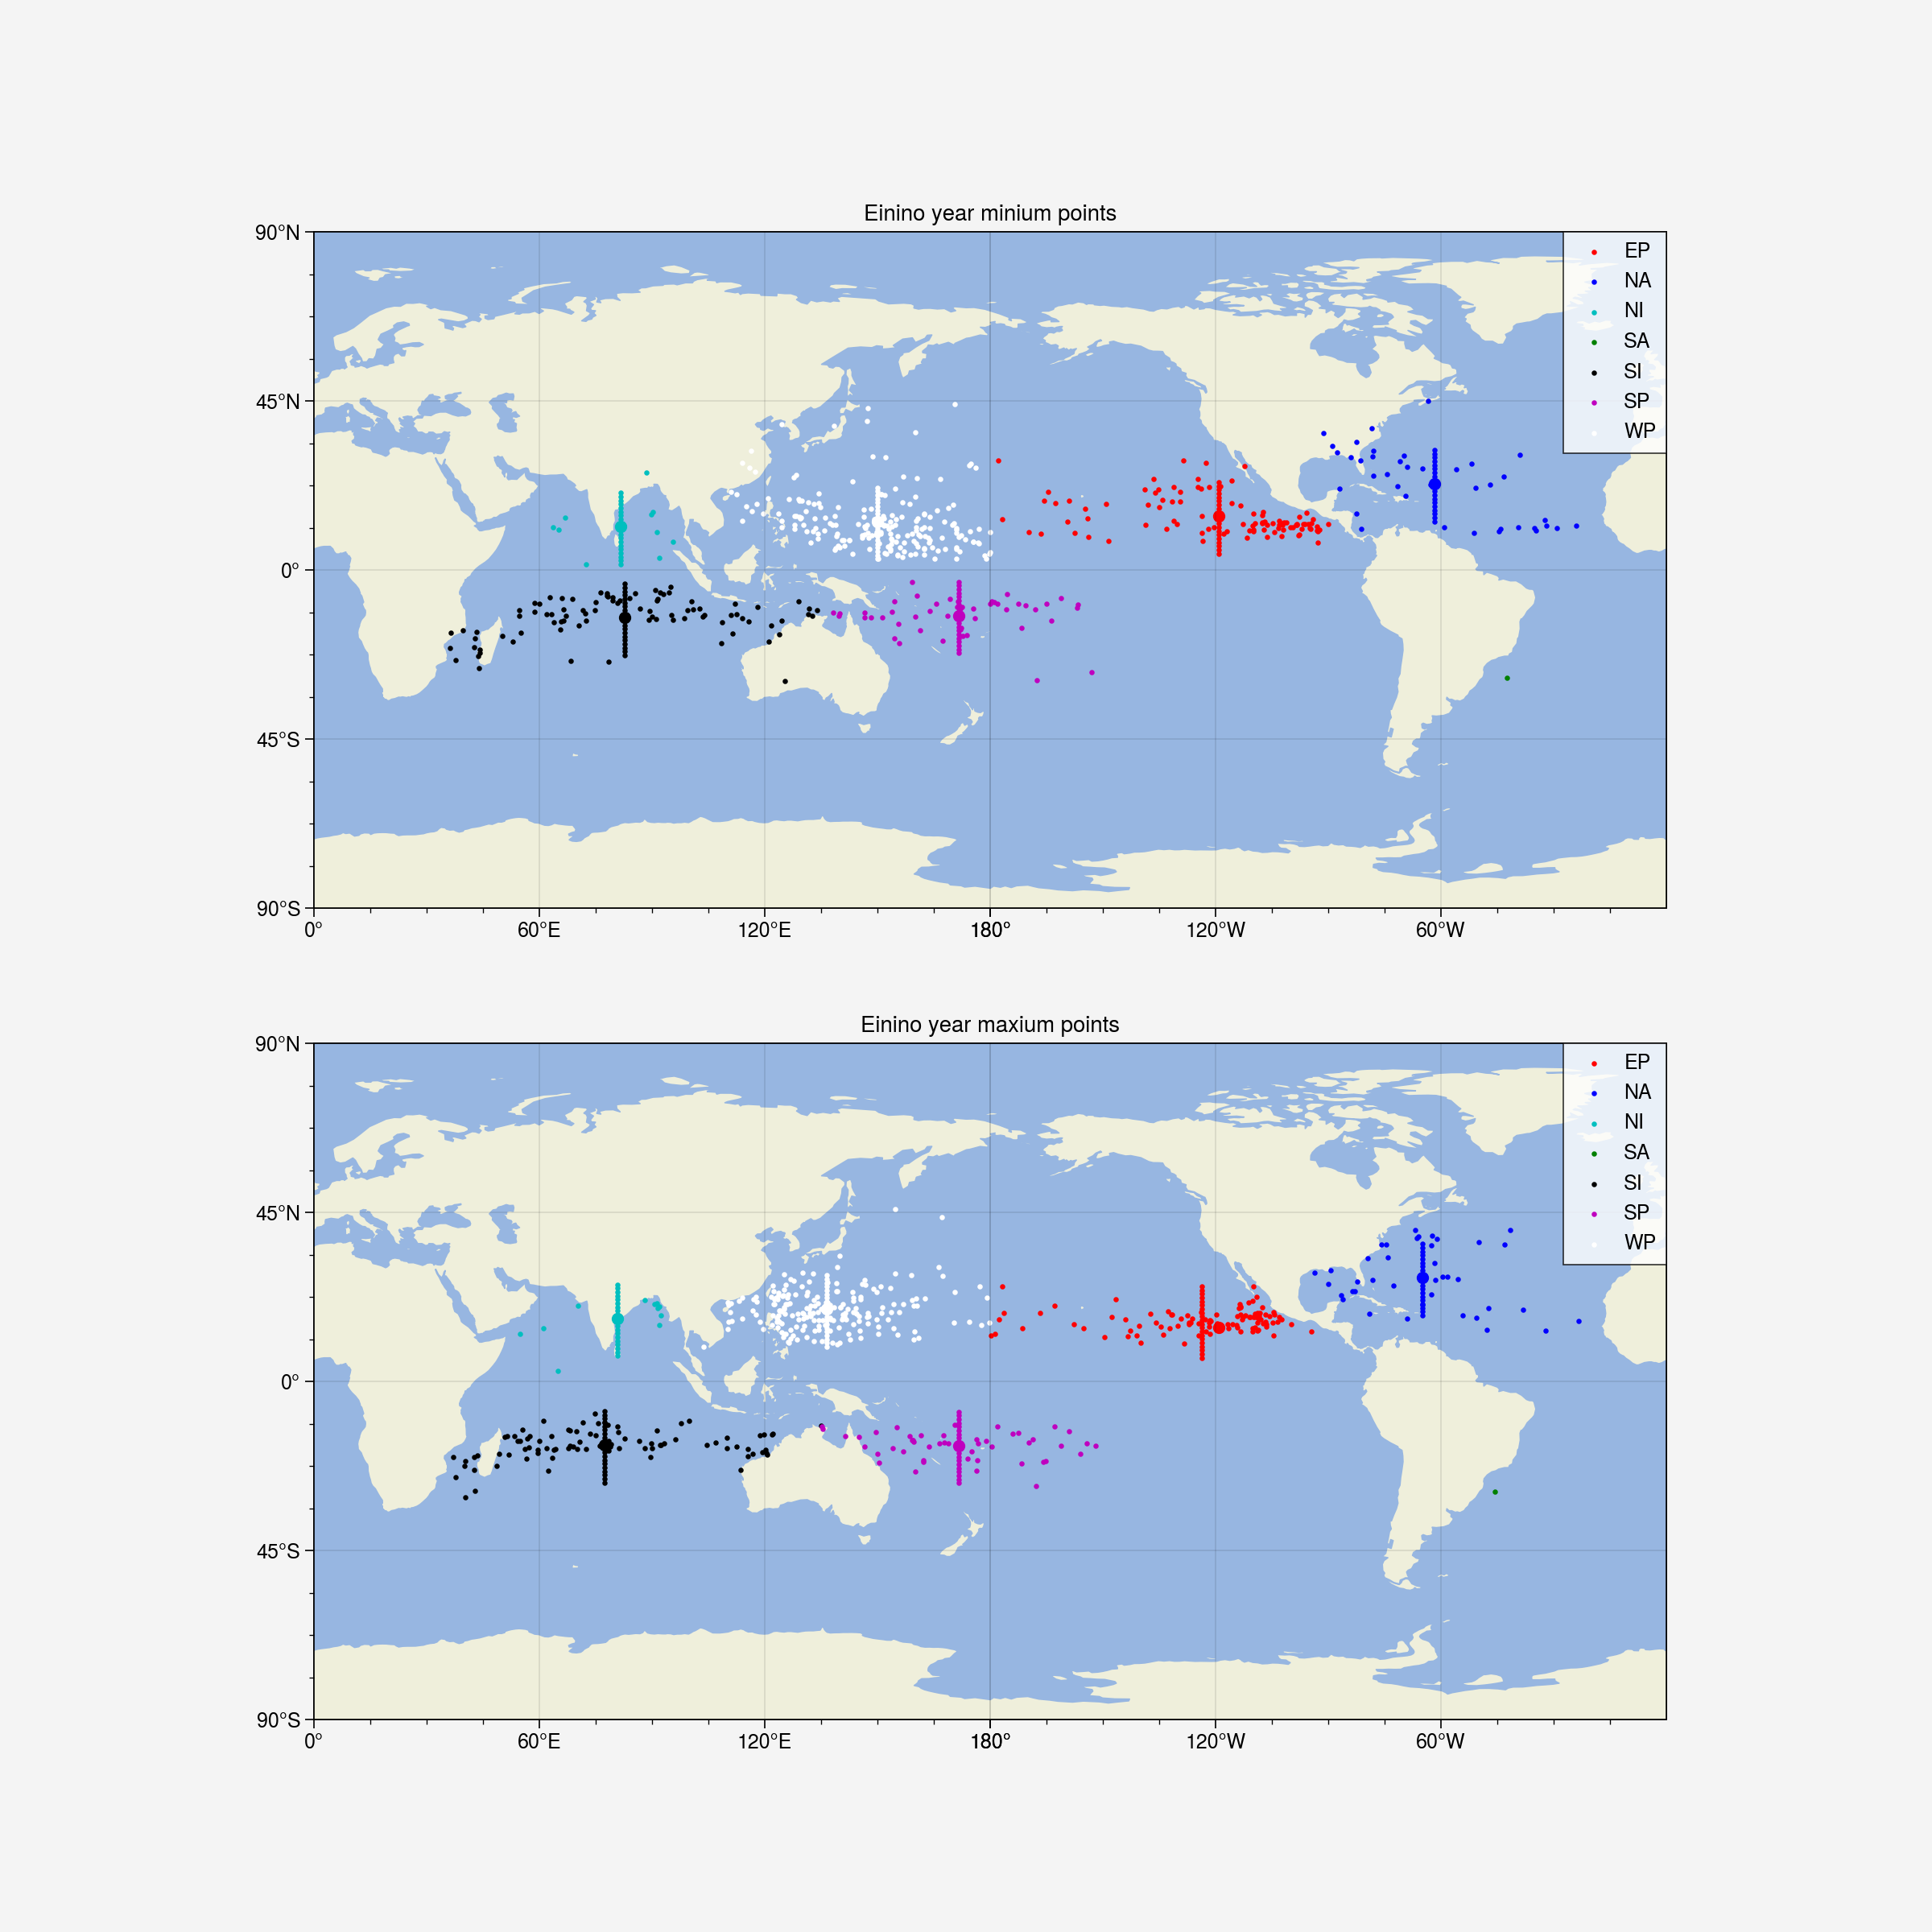

In [111]:
map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 12),
    subplot_kw={'projection': map_proj}
)

ax =fig.add_subplot(2,1,1,projection=map_proj)
ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_title("Einino year minium points")
# basin = 'EP'  红色
ax.scatter(df_einino_wind_speed_min_ep['LON'], df_einino_wind_speed_min_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
lon_mean_ep_min, lat_mean_ep_min = mean_lon_lat(df_einino_wind_speed_min_ep)
# 竖线
ax.scatter([lon_mean_ep_min for _ in range(20)], 
           np.arange(lat_mean_ep_min-10, lat_mean_ep_min + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NA"  蓝色
ax.scatter(df_einino_wind_speed_min_na['LON'], df_einino_wind_speed_min_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_min, lat_mean_na_min = mean_lon_lat(df_einino_wind_speed_min_na)
# 竖线
ax.scatter([lon_mean_na_min for _ in range(20)], 
           np.arange(lat_mean_na_min-10, lat_mean_na_min + 10, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_na_min], [lat_mean_na_min],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NI"  天蓝色
ax.scatter(df_einino_wind_speed_min_ni['LON'], df_einino_wind_speed_min_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_min, lat_mean_ni_min = mean_lon_lat(df_einino_wind_speed_min_ni)
# 竖线
ax.scatter([lon_mean_ni_min for _ in range(20)], 
           np.arange(lat_mean_ni_min-10, lat_mean_ni_min + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ni_min], [lat_mean_ni_min],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SA"  绿色
ax.scatter(df_einino_wind_speed_min_sa['LON'], df_einino_wind_speed_min_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# basin = "SI" 黑色
ax.scatter(df_einino_wind_speed_min_si['LON'], df_einino_wind_speed_min_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_min, lat_mean_si_min = mean_lon_lat(df_einino_wind_speed_min_si)
# 竖线
ax.scatter([lon_mean_si_min for _ in range(20)], 
           np.arange(lat_mean_si_min-10, lat_mean_si_min + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_si_min], [lat_mean_si_min],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SP" 紫色
ax.scatter(df_einino_wind_speed_min_sp['LON'], df_einino_wind_speed_min_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_einino_wind_speed_min_sp['LON'] = df_einino_wind_speed_min_sp['LON'].mask(df_einino_wind_speed_min_sp['LON'] < 0, (df_einino_wind_speed_min_sp['LON'] + 360))
lon_mean_sp_min = round(df_einino_wind_speed_min_sp["LON"].mean(), 2)
lat_mean_sp_min = round(df_einino_wind_speed_min_sp["LAT"].mean(), 2)
# 竖线
ax.scatter([lon_mean_sp_min for _ in range(20)], 
           np.arange(lat_mean_sp_min-10, lat_mean_sp_min + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_sp_min], [lat_mean_sp_min],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "WP" 白色
ax.scatter(df_einino_wind_speed_min_wp['LON'], df_einino_wind_speed_min_wp['LAT'],
        s=3, c = 'w', marker = 'o',  label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_min, lat_mean_wp_min = mean_lon_lat(df_einino_wind_speed_min_wp)
# 竖线
ax.scatter([lon_mean_wp_min for _ in range(20)], 
           np.arange(lat_mean_wp_min-10, lat_mean_wp_min + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_wp_min], [lat_mean_wp_min],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
plt.legend()


ax1 =fig.add_subplot(2,1,2,projection=map_proj)
ax1.set_global()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_title("Einino year maxium points")
# basin = 'EP'  红色
ax1.scatter(df_einino_wind_speed_max_ep['LON'], df_einino_wind_speed_max_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
lon_mean_ep_max, lat_mean_ep_max = mean_lon_lat(df_einino_wind_speed_max_ep)
# 竖线
ax1.scatter([lon_mean_ep_max for _ in range(20)], 
           np.arange(lat_mean_ep_max-10, lat_mean_ep_max + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NA"  蓝色
ax1.scatter(df_einino_wind_speed_max_na['LON'], df_einino_wind_speed_max_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_max, lat_mean_na_max = mean_lon_lat(df_einino_wind_speed_max_na)
# 竖线
ax1.scatter([lon_mean_na_max for _ in range(20)], 
           np.arange(lat_mean_na_max-10, lat_mean_na_max + 10, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_na_max], [lat_mean_na_max],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NI"  天蓝色
ax1.scatter(df_einino_wind_speed_max_ni['LON'], df_einino_wind_speed_max_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_max, lat_mean_ni_max = mean_lon_lat(df_einino_wind_speed_max_ni)
# 竖线
ax1.scatter([lon_mean_ni_max for _ in range(20)], 
           np.arange(lat_mean_ni_max-10, lat_mean_ni_max + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ni_max], [lat_mean_ni_max],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SA"  绿色
ax1.scatter(df_einino_wind_speed_max_sa['LON'], df_einino_wind_speed_max_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# basin = "SI" 黑色
ax1.scatter(df_einino_wind_speed_max_si['LON'], df_einino_wind_speed_max_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_max, lat_mean_si_max = mean_lon_lat(df_einino_wind_speed_max_si)
# 竖线
ax1.scatter([lon_mean_si_max for _ in range(20)], 
           np.arange(lat_mean_si_max-10, lat_mean_si_max + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_si_max], [lat_mean_si_max],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SP" 紫色
ax1.scatter(df_einino_wind_speed_max_sp['LON'], df_einino_wind_speed_max_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_einino_wind_speed_max_sp['LON'] = df_einino_wind_speed_max_sp['LON'].mask(df_einino_wind_speed_max_sp['LON'] < 0, (df_einino_wind_speed_max_sp['LON'] + 360))
lon_mean_sp_max = round(df_einino_wind_speed_max_sp["LON"].mean(), 2)
lat_mean_sp_max = round(df_einino_wind_speed_max_sp["LAT"].mean(), 2)
# 竖线
ax1.scatter([lon_mean_sp_max for _ in range(20)], 
           np.arange(lat_mean_sp_max-10, lat_mean_sp_max + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_sp_max], [lat_mean_sp_max],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "WP" 白色
ax1.scatter(df_einino_wind_speed_max_wp['LON'], df_einino_wind_speed_max_wp['LAT'],
        s=3, c = 'w', marker = 'o', label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_max, lat_mean_wp_max = mean_lon_lat(df_einino_wind_speed_max_wp)
# 竖线
ax1.scatter([lon_mean_wp_max for _ in range(20)], 
           np.arange(lat_mean_wp_max-10, lat_mean_wp_max + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_wp_max], [lat_mean_wp_max],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())

plt.legend()

# fig = plt.figure(figsize=[20, 20])

In [93]:
lon_mean_sp_min

51.57

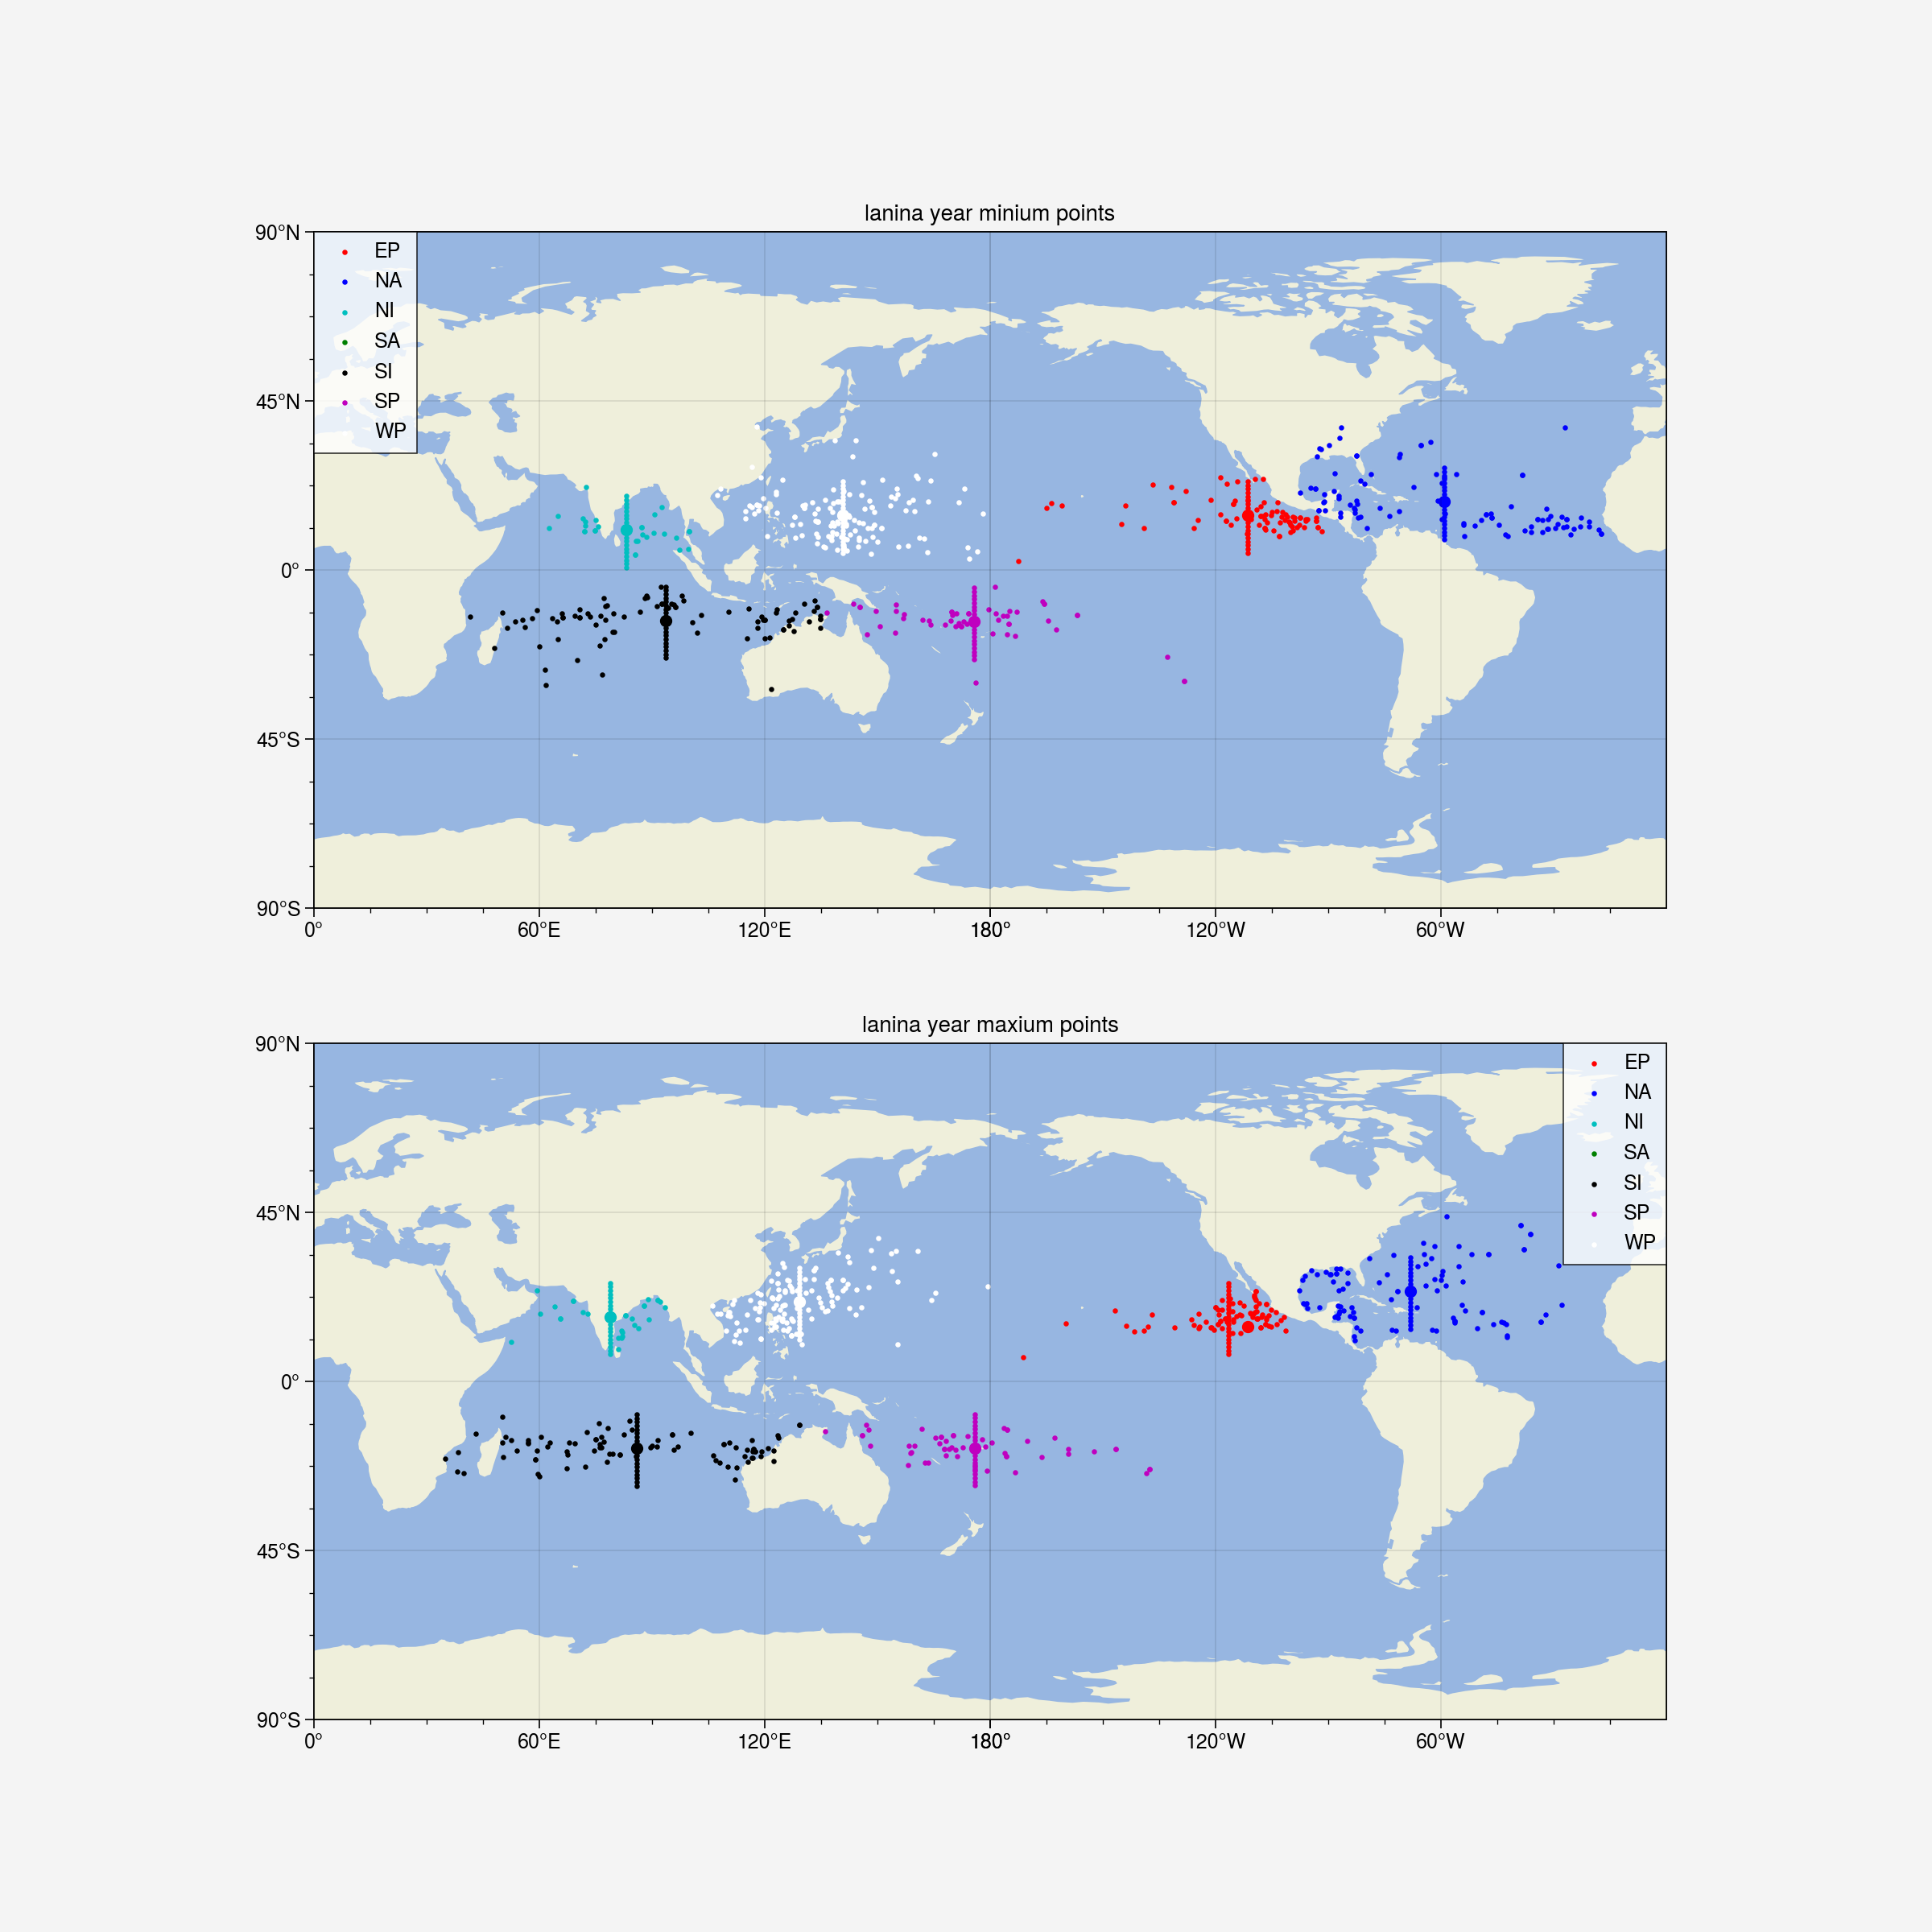

In [121]:

# basin = 'EP'  红色
df_lanina_wind_speed_min_ep, df_lanina_wind_speed_max_ep = basin_wind_speed(df, 'EP', lanina)
# basin = "NA"  蓝色
df_lanina_wind_speed_min_na, df_lanina_wind_speed_max_na = basin_wind_speed(df, 'NA', lanina)
# basin = "NI"  天蓝色
df_lanina_wind_speed_min_ni, df_lanina_wind_speed_max_ni = basin_wind_speed(df, 'NI', lanina)
# basin = "SA"  绿色
df_lanina_wind_speed_min_sa, df_lanina_wind_speed_max_sa = basin_wind_speed(df, 'SA', lanina)
# basin = "SI" 黑色
df_lanina_wind_speed_min_si, df_lanina_wind_speed_max_si = basin_wind_speed(df, 'SI', lanina)
# basin = "SP" 紫色
df_lanina_wind_speed_min_sp, df_lanina_wind_speed_max_sp = basin_wind_speed(df, 'SP', lanina)
# basin = "WP" 白色
df_lanina_wind_speed_min_wp, df_lanina_wind_speed_max_wp = basin_wind_speed(df, 'WP', lanina)

map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 12),
    subplot_kw={'projection': map_proj}
)

ax =fig.add_subplot(2,1,1,projection=map_proj)
ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_title("lanina year minium points")
# basin = 'EP'  红色
ax.scatter(df_lanina_wind_speed_min_ep['LON'], df_lanina_wind_speed_min_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
lon_mean_ep_min, lat_mean_ep_min = mean_lon_lat(df_lanina_wind_speed_min_ep)
# 竖线
ax.scatter([lon_mean_ep_min for _ in range(20)], 
           np.arange(lat_mean_ep_min-10, lat_mean_ep_min + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NA"  蓝色
ax.scatter(df_lanina_wind_speed_min_na['LON'], df_lanina_wind_speed_min_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_min, lat_mean_na_min = mean_lon_lat(df_lanina_wind_speed_min_na)
# 竖线
ax.scatter([lon_mean_na_min for _ in range(20)], 
           np.arange(lat_mean_na_min-10, lat_mean_na_min + 10, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_na_min], [lat_mean_na_min],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NI"  天蓝色
ax.scatter(df_lanina_wind_speed_min_ni['LON'], df_lanina_wind_speed_min_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_min, lat_mean_ni_min = mean_lon_lat(df_lanina_wind_speed_min_ni)
# 竖线
ax.scatter([lon_mean_ni_min for _ in range(20)], 
           np.arange(lat_mean_ni_min-10, lat_mean_ni_min + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ni_min], [lat_mean_ni_min],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SA"  绿色
ax.scatter(df_lanina_wind_speed_min_sa['LON'], df_lanina_wind_speed_min_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# basin = "SI" 黑色
ax.scatter(df_lanina_wind_speed_min_si['LON'], df_lanina_wind_speed_min_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_min, lat_mean_si_min = mean_lon_lat(df_lanina_wind_speed_min_si)
# 竖线
ax.scatter([lon_mean_si_min for _ in range(20)], 
           np.arange(lat_mean_si_min-10, lat_mean_si_min + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_si_min], [lat_mean_si_min],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SP" 紫色
ax.scatter(df_lanina_wind_speed_min_sp['LON'], df_lanina_wind_speed_min_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_lanina_wind_speed_min_sp['LON'] = df_lanina_wind_speed_min_sp['LON'].mask(df_lanina_wind_speed_min_sp['LON'] < 0, (df_lanina_wind_speed_min_sp['LON'] + 360))
lon_mean_sp_min = round(df_lanina_wind_speed_min_sp["LON"].mean(), 2)
lat_mean_sp_min = round(df_lanina_wind_speed_min_sp["LAT"].mean(), 2)
# 竖线
ax.scatter([lon_mean_sp_min for _ in range(20)], 
           np.arange(lat_mean_sp_min-10, lat_mean_sp_min + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_sp_min], [lat_mean_sp_min],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "WP" 白色
ax.scatter(df_lanina_wind_speed_min_wp['LON'], df_lanina_wind_speed_min_wp['LAT'],
        s=3, c = 'w', marker = 'o',  label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_min, lat_mean_wp_min = mean_lon_lat(df_lanina_wind_speed_min_wp)
# 竖线
ax.scatter([lon_mean_wp_min for _ in range(20)], 
           np.arange(lat_mean_wp_min-10, lat_mean_wp_min + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_wp_min], [lat_mean_wp_min],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
plt.legend()


ax1 =fig.add_subplot(2,1,2,projection=map_proj)
ax1.set_global()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_title("lanina year maxium points")
# basin = 'EP'  红色
ax1.scatter(df_lanina_wind_speed_max_ep['LON'], df_lanina_wind_speed_max_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
lon_mean_ep_max, lat_mean_ep_max = mean_lon_lat(df_lanina_wind_speed_max_ep)
# 竖线
ax1.scatter([lon_mean_ep_max for _ in range(20)], 
           np.arange(lat_mean_ep_max-10, lat_mean_ep_max + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NA"  蓝色
ax1.scatter(df_lanina_wind_speed_max_na['LON'], df_lanina_wind_speed_max_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_max, lat_mean_na_max = mean_lon_lat(df_lanina_wind_speed_max_na)
# 竖线
ax1.scatter([lon_mean_na_max for _ in range(20)], 
           np.arange(lat_mean_na_max - 10, lat_mean_na_max + 9, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_na_max], [lat_mean_na_max],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NI"  天蓝色
ax1.scatter(df_lanina_wind_speed_max_ni['LON'], df_lanina_wind_speed_max_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_max, lat_mean_ni_max = mean_lon_lat(df_lanina_wind_speed_max_ni)
# 竖线
ax1.scatter([lon_mean_ni_max for _ in range(20)], 
           np.arange(lat_mean_ni_max-10, lat_mean_ni_max + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ni_max], [lat_mean_ni_max],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SA"  绿色
ax1.scatter(df_lanina_wind_speed_max_sa['LON'], df_lanina_wind_speed_max_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# basin = "SI" 黑色
ax1.scatter(df_lanina_wind_speed_max_si['LON'], df_lanina_wind_speed_max_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_max, lat_mean_si_max = mean_lon_lat(df_lanina_wind_speed_max_si)
# 竖线
ax1.scatter([lon_mean_si_max for _ in range(20)], 
           np.arange(lat_mean_si_max-10, lat_mean_si_max + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_si_max], [lat_mean_si_max],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SP" 紫色
ax1.scatter(df_lanina_wind_speed_max_sp['LON'], df_lanina_wind_speed_max_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_lanina_wind_speed_max_sp['LON'] = df_lanina_wind_speed_max_sp['LON'].mask(df_lanina_wind_speed_max_sp['LON'] < 0, (df_lanina_wind_speed_max_sp['LON'] + 360))
lon_mean_sp_max = round(df_lanina_wind_speed_max_sp["LON"].mean(), 2)
lat_mean_sp_max = round(df_lanina_wind_speed_max_sp["LAT"].mean(), 2)
# 竖线
ax1.scatter([lon_mean_sp_max for _ in range(20)], 
           np.arange(lat_mean_sp_max-10, lat_mean_sp_max + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_sp_max], [lat_mean_sp_max],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "WP" 白色
ax1.scatter(df_lanina_wind_speed_max_wp['LON'], df_lanina_wind_speed_max_wp['LAT'],
        s=3, c = 'w', marker = 'o', label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_max, lat_mean_wp_max = mean_lon_lat(df_lanina_wind_speed_max_wp)
# 竖线
ax1.scatter([lon_mean_wp_max for _ in range(20)], 
           np.arange(lat_mean_wp_max-10, lat_mean_wp_max + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_wp_max], [lat_mean_wp_max],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())

plt.legend()

# fig = plt.figure(figsize=[20, 20])

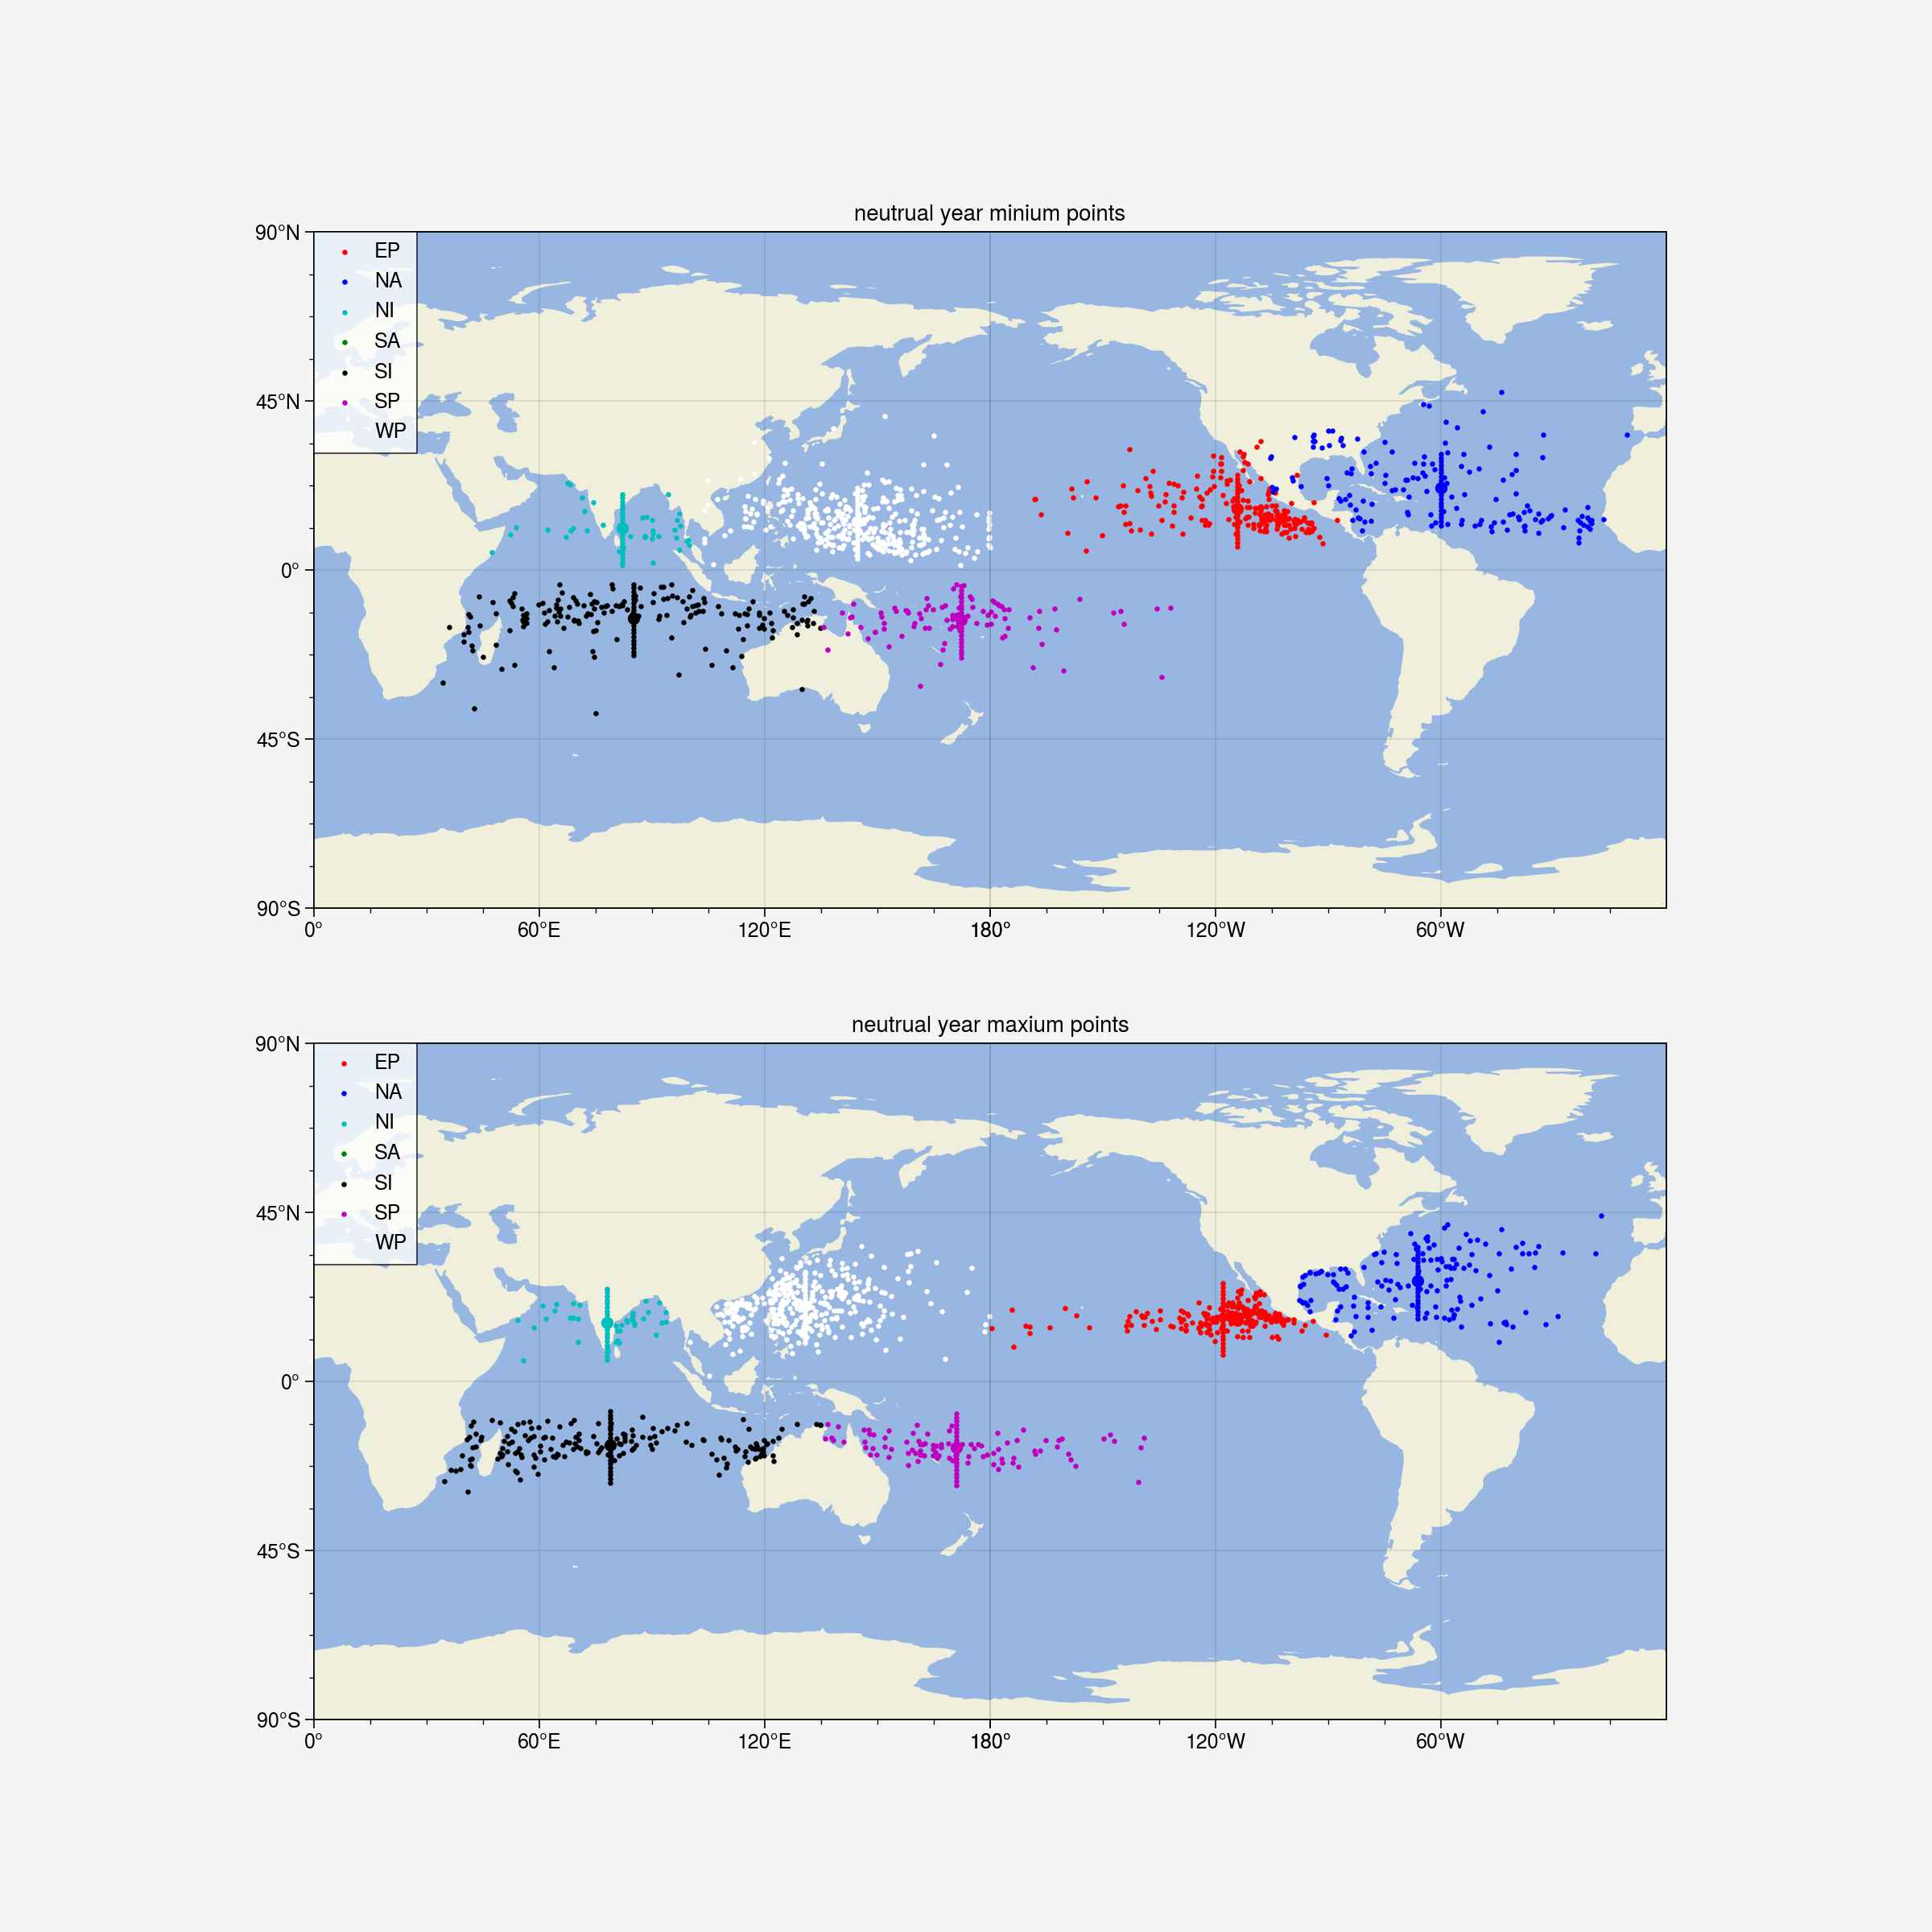

In [122]:
# basin = 'EP'  红色
df_neutrual_wind_speed_min_ep, df_neutrual_wind_speed_max_ep = basin_wind_speed(df, 'EP', neutrual)
# basin = "NA"  蓝色
df_neutrual_wind_speed_min_na, df_neutrual_wind_speed_max_na = basin_wind_speed(df, 'NA', neutrual)
# basin = "NI"  天蓝色
df_neutrual_wind_speed_min_ni, df_neutrual_wind_speed_max_ni = basin_wind_speed(df, 'NI', neutrual)
# basin = "SA"  绿色
df_neutrual_wind_speed_min_sa, df_neutrual_wind_speed_max_sa = basin_wind_speed(df, 'SA', neutrual)
# basin = "SI" 黑色
df_neutrual_wind_speed_min_si, df_neutrual_wind_speed_max_si = basin_wind_speed(df, 'SI', neutrual)
# basin = "SP" 紫色
df_neutrual_wind_speed_min_sp, df_neutrual_wind_speed_max_sp = basin_wind_speed(df, 'SP', neutrual)
# basin = "WP" 白色
df_neutrual_wind_speed_min_wp, df_neutrual_wind_speed_max_wp = basin_wind_speed(df, 'WP', neutrual)

map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 12),
    subplot_kw={'projection': map_proj}
)

ax =fig.add_subplot(2,1,1,projection=map_proj)
ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_title("neutrual year minium points")
# basin = 'EP'  红色
ax.scatter(df_neutrual_wind_speed_min_ep['LON'], df_neutrual_wind_speed_min_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
lon_mean_ep_min, lat_mean_ep_min = mean_lon_lat(df_neutrual_wind_speed_min_ep)
# 竖线
ax.scatter([lon_mean_ep_min for _ in range(20)], 
           np.arange(lat_mean_ep_min-10, lat_mean_ep_min + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NA"  蓝色
ax.scatter(df_neutrual_wind_speed_min_na['LON'], df_neutrual_wind_speed_min_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_min, lat_mean_na_min = mean_lon_lat(df_neutrual_wind_speed_min_na)
# 竖线
ax.scatter([lon_mean_na_min for _ in range(20)], 
           np.arange(lat_mean_na_min-10, lat_mean_na_min + 10, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_na_min], [lat_mean_na_min],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NI"  天蓝色
ax.scatter(df_neutrual_wind_speed_min_ni['LON'], df_neutrual_wind_speed_min_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_min, lat_mean_ni_min = mean_lon_lat(df_neutrual_wind_speed_min_ni)
# 竖线
ax.scatter([lon_mean_ni_min for _ in range(20)], 
           np.arange(lat_mean_ni_min-10, lat_mean_ni_min + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_ni_min], [lat_mean_ni_min],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SA"  绿色
ax.scatter(df_neutrual_wind_speed_min_sa['LON'], df_neutrual_wind_speed_min_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# basin = "SI" 黑色
ax.scatter(df_neutrual_wind_speed_min_si['LON'], df_neutrual_wind_speed_min_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_min, lat_mean_si_min = mean_lon_lat(df_neutrual_wind_speed_min_si)
# 竖线
ax.scatter([lon_mean_si_min for _ in range(20)], 
           np.arange(lat_mean_si_min-10, lat_mean_si_min + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_si_min], [lat_mean_si_min],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SP" 紫色
ax.scatter(df_neutrual_wind_speed_min_sp['LON'], df_neutrual_wind_speed_min_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_neutrual_wind_speed_min_sp['LON'] = df_neutrual_wind_speed_min_sp['LON'].mask(df_neutrual_wind_speed_min_sp['LON'] < 0, (df_neutrual_wind_speed_min_sp['LON'] + 360))
lon_mean_sp_min = round(df_neutrual_wind_speed_min_sp["LON"].mean(), 2)
lat_mean_sp_min = round(df_neutrual_wind_speed_min_sp["LAT"].mean(), 2)
# 竖线
ax.scatter([lon_mean_sp_min for _ in range(20)], 
           np.arange(lat_mean_sp_min-10, lat_mean_sp_min + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_sp_min], [lat_mean_sp_min],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "WP" 白色
ax.scatter(df_neutrual_wind_speed_min_wp['LON'], df_neutrual_wind_speed_min_wp['LAT'],
        s=3, c = 'w', marker = 'o',  label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_min, lat_mean_wp_min = mean_lon_lat(df_neutrual_wind_speed_min_wp)
# 竖线
ax.scatter([lon_mean_wp_min for _ in range(20)], 
           np.arange(lat_mean_wp_min-10, lat_mean_wp_min + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax.scatter([lon_mean_wp_min], [lat_mean_wp_min],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
plt.legend()


ax1 =fig.add_subplot(2,1,2,projection=map_proj)
ax1.set_global()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_title("neutrual year maxium points")
# basin = 'EP'  红色
ax1.scatter(df_neutrual_wind_speed_max_ep['LON'], df_neutrual_wind_speed_max_ep['LAT'],
        s=3, c = 'r', marker = 'o', label='EP',
        transform=ccrs.PlateCarree())
lon_mean_ep_max, lat_mean_ep_max = mean_lon_lat(df_neutrual_wind_speed_max_ep)
# 竖线
ax1.scatter([lon_mean_ep_max for _ in range(20)], 
           np.arange(lat_mean_ep_max-10, lat_mean_ep_max + 10, 1).tolist(), 
           s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ep_min], [lat_mean_ep_min],s=24, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NA"  蓝色
ax1.scatter(df_neutrual_wind_speed_max_na['LON'], df_neutrual_wind_speed_max_na['LAT'],
        s=3, c = 'b', marker = 'o', label='NA',
        transform=ccrs.PlateCarree())
lon_mean_na_max, lat_mean_na_max = mean_lon_lat(df_neutrual_wind_speed_max_na)
# 竖线
ax1.scatter([lon_mean_na_max for _ in range(20)], 
           np.arange(lat_mean_na_max - 10, lat_mean_na_max + 9, 1).tolist(), 
           s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_na_max], [lat_mean_na_max],s=24, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "NI"  天蓝色
ax1.scatter(df_neutrual_wind_speed_max_ni['LON'], df_neutrual_wind_speed_max_ni['LAT'],
        s=3, c = 'c', marker = 'o', label='NI',
        transform=ccrs.PlateCarree())
lon_mean_ni_max, lat_mean_ni_max = mean_lon_lat(df_neutrual_wind_speed_max_ni)
# 竖线
ax1.scatter([lon_mean_ni_max for _ in range(20)], 
           np.arange(lat_mean_ni_max-10, lat_mean_ni_max + 10, 1).tolist(), 
           s=3, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_ni_max], [lat_mean_ni_max],s=24, c = 'c', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SA"  绿色
ax1.scatter(df_neutrual_wind_speed_max_sa['LON'], df_neutrual_wind_speed_max_sa['LAT'],
        s=3, c = 'g', marker = 'o', label="SA",
        transform=ccrs.PlateCarree())

# basin = "SI" 黑色
ax1.scatter(df_neutrual_wind_speed_max_si['LON'], df_neutrual_wind_speed_max_si['LAT'],
        s=3, c = 'k', marker = 'o', label='SI',
        transform=ccrs.PlateCarree())
lon_mean_si_max, lat_mean_si_max = mean_lon_lat(df_neutrual_wind_speed_max_si)
# 竖线
ax1.scatter([lon_mean_si_max for _ in range(20)], 
           np.arange(lat_mean_si_max-10, lat_mean_si_max + 10, 1).tolist(), 
           s=3, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_si_max], [lat_mean_si_max],s=24, c = 'k', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "SP" 紫色
ax1.scatter(df_neutrual_wind_speed_max_sp['LON'], df_neutrual_wind_speed_max_sp['LAT'],
        s=3, c = 'm', marker = 'o', label='SP',
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_neutrual_wind_speed_max_sp['LON'] = df_neutrual_wind_speed_max_sp['LON'].mask(df_neutrual_wind_speed_max_sp['LON'] < 0, (df_neutrual_wind_speed_max_sp['LON'] + 360))
lon_mean_sp_max = round(df_neutrual_wind_speed_max_sp["LON"].mean(), 2)
lat_mean_sp_max = round(df_neutrual_wind_speed_max_sp["LAT"].mean(), 2)
# 竖线
ax1.scatter([lon_mean_sp_max for _ in range(20)], 
           np.arange(lat_mean_sp_max-10, lat_mean_sp_max + 10, 1).tolist(), 
           s=3, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_sp_max], [lat_mean_sp_max],s=24, c = 'm', marker = 'o', 
        transform=ccrs.PlateCarree())

# basin = "WP" 白色
ax1.scatter(df_neutrual_wind_speed_max_wp['LON'], df_neutrual_wind_speed_max_wp['LAT'],
        s=3, c = 'w', marker = 'o', label='WP',
        transform=ccrs.PlateCarree())
lon_mean_wp_max, lat_mean_wp_max = mean_lon_lat(df_neutrual_wind_speed_max_wp)
# 竖线
ax1.scatter([lon_mean_wp_max for _ in range(20)], 
           np.arange(lat_mean_wp_max-10, lat_mean_wp_max + 10, 1).tolist(), 
           s=3, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())
# 点
ax1.scatter([lon_mean_wp_max], [lat_mean_wp_max],s=24, c = 'w', marker = 'o', 
        transform=ccrs.PlateCarree())

plt.legend()

# fig = plt.figure(figsize=[20, 20])

===开始计算einino最小风速经纬度===
纬度最小值为-29.56，最大值为44.96
经度最小值为-179.50，最大值为180.00
纬度中间值为7.70，经度中间值为0.25
===开始计算einino最大风速经纬度===
纬度最小值为-30.76，最大值为45.90
经度最小值为-179.59，最大值为178.93
纬度中间值为7.57，经度中间值为-0.33


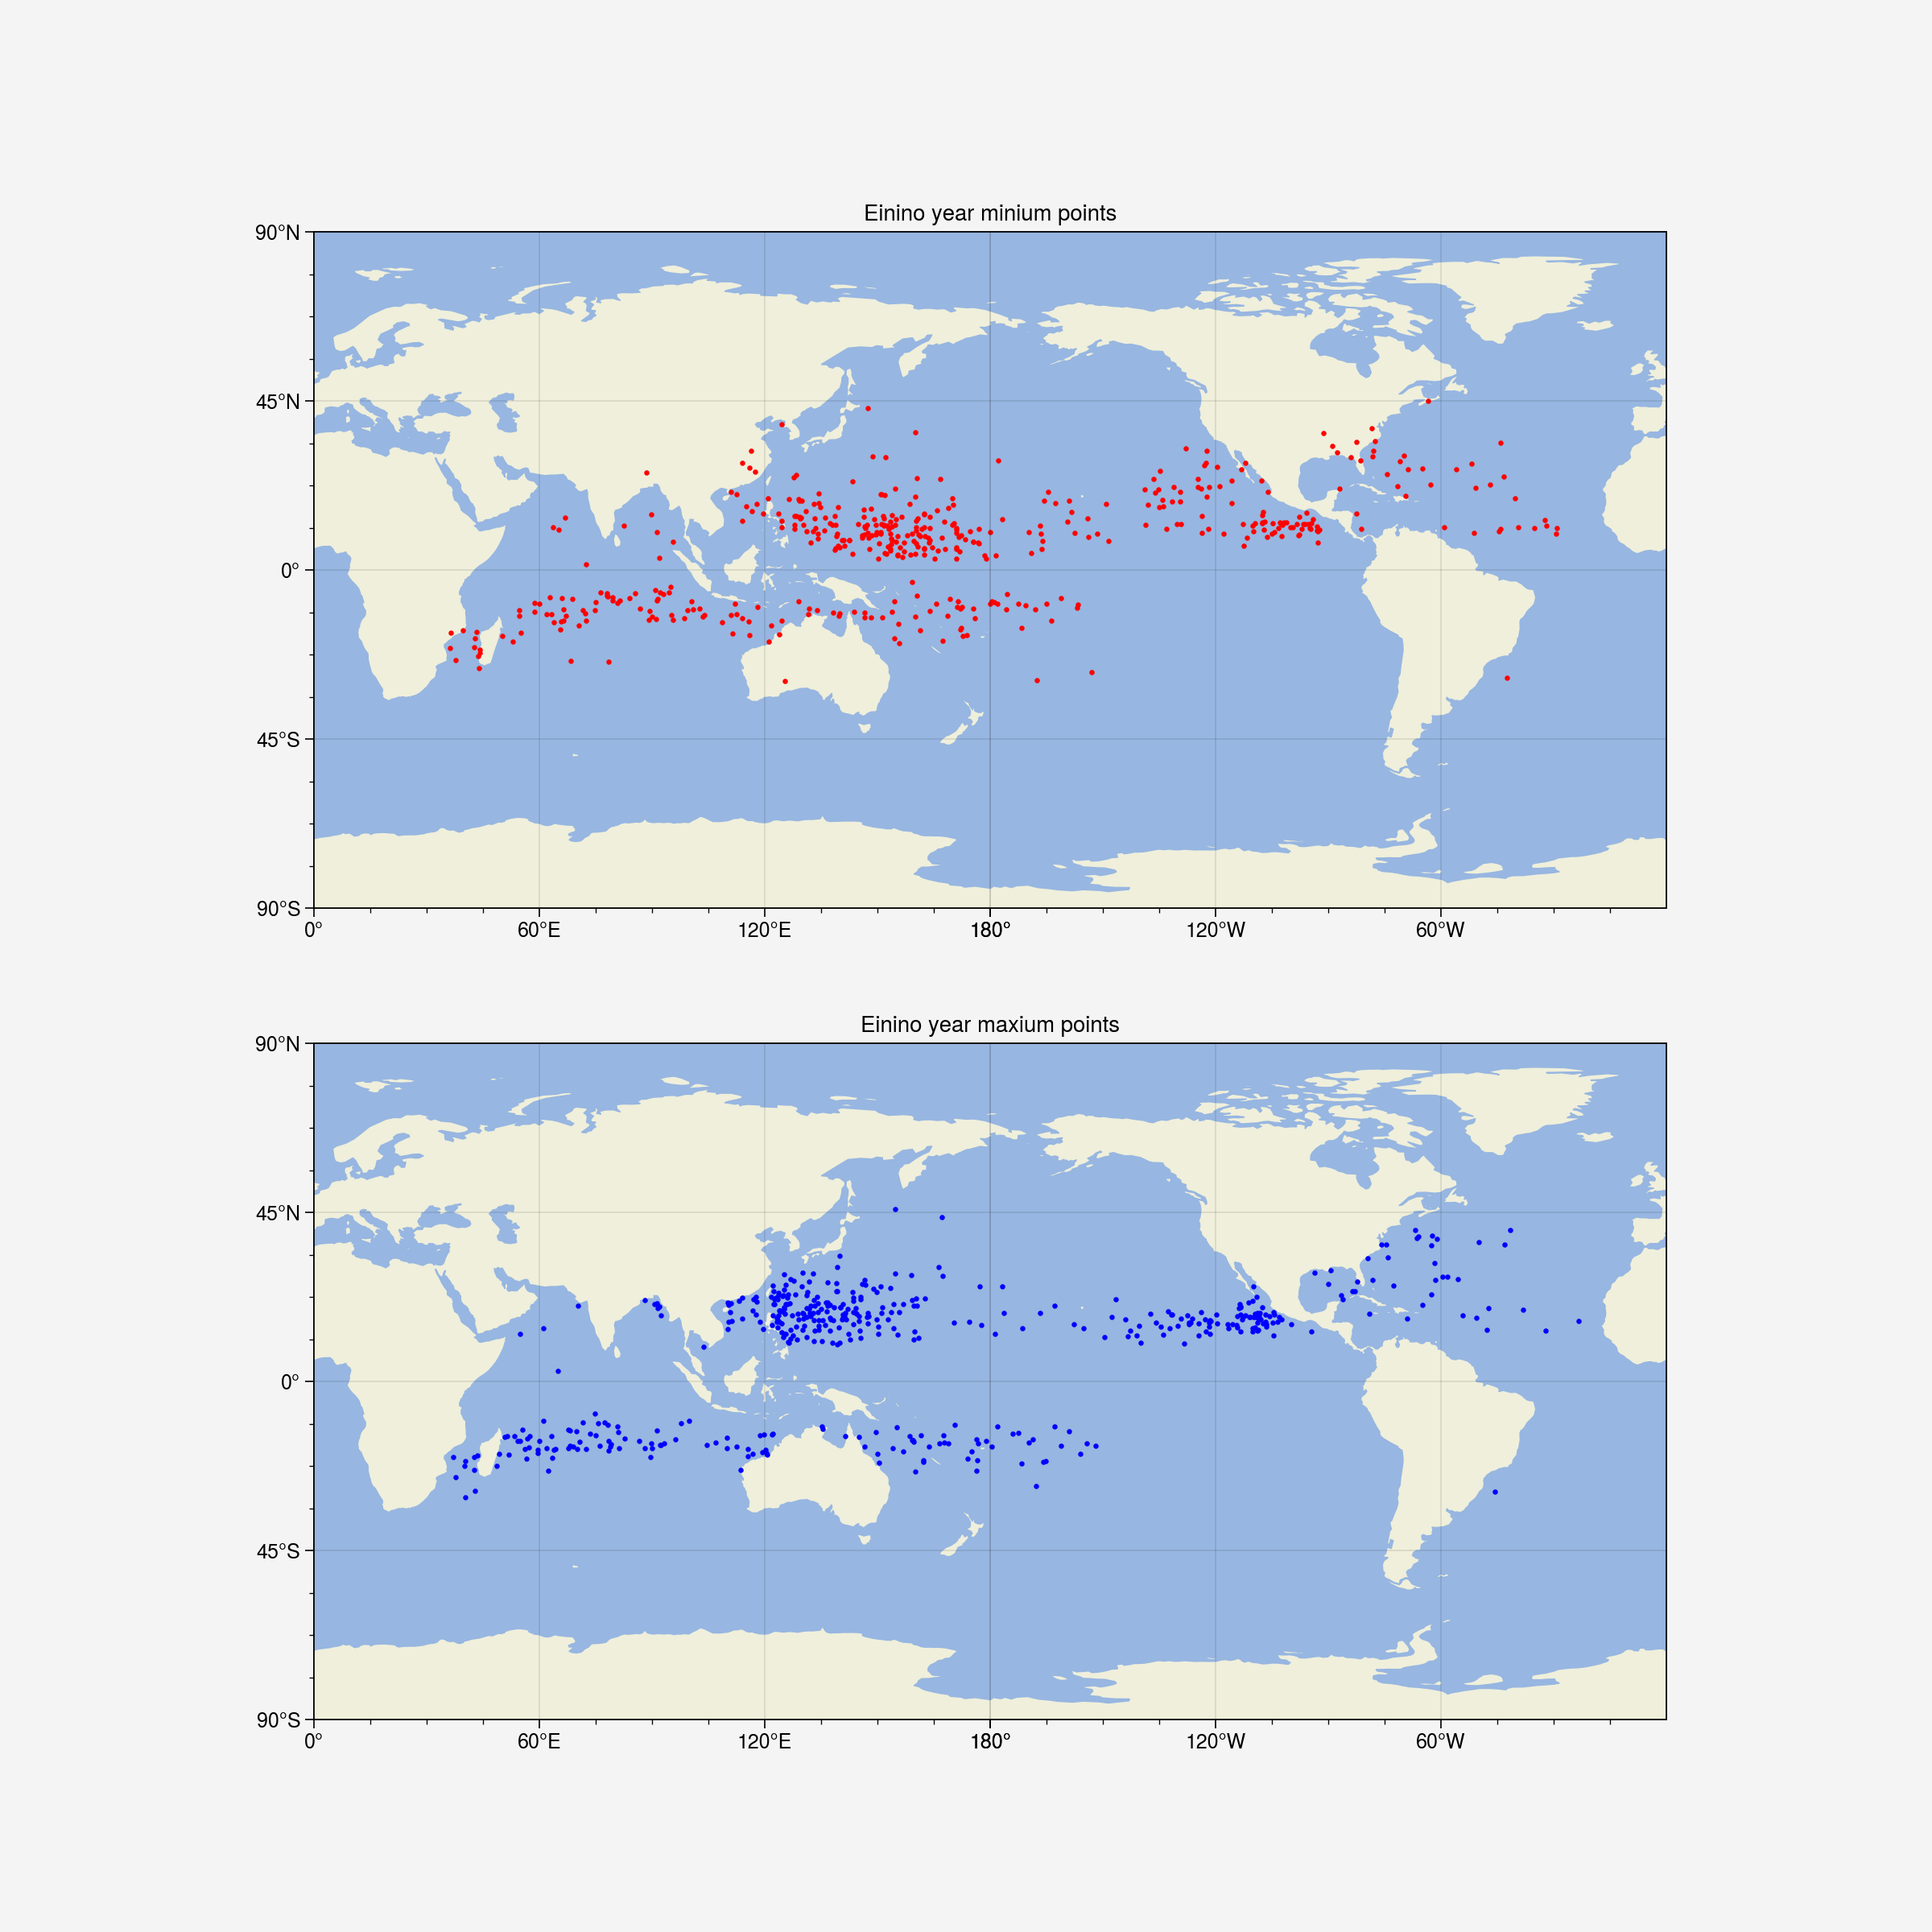

In [32]:
einino = [1982,1986,1987,1991,1994,1997,2002,2004,2009,2015]
# einino = [1986,1987,1991,1994,1997,2002,2004,2009,2015]
lanina = [1988, 1995, 1998, 1998, 2000, 2007, 2010, 2011, 2016, 2020, 2021]
neutrual = [1983, 1984, 1985, 1989, 1990, 1992, 1993, 1995, 1996, 2001, 2003, 2005, 2006, 2008, 2012, 2013, 2014, 2017, 2018, 2019]

# basin 在ep这一区的洋 
# df_ep = df[df['BASIN'] == 'EP']

# 厄尔尼诺风速最大值最小值经纬度列表 
df_einino_wind_speed_min, df_einino_wind_speed_max= lat_and_lon_usa_wind_speed(df, einino)


print("===开始计算einino最小风速经纬度===")
df_lat_MIN = df_einino_wind_speed_min.sort_values(by = ['LAT']).reset_index()
# LON列里面的值大于180的value，用value-360代替
df_lon_MIN = df_einino_wind_speed_min.sort_values(by = ['LON']).reset_index()

df_lon_MIN['LON'] = df_lon_MIN['LON'].mask(df_lon_MIN['LON'] > 180, (df_lon_MIN['LON'] - 360))

df_lon_MIN = df_lon_MIN.sort_values(by = ['LON']).reset_index()
"""
找出（25%, 75%)纬度范围(low_point_lat_MIN, up_point_lat_MIN)
"""
# low_line_lat_MIN = int(df_lat_MIN.shape[0] / 4)
# up_line_lat_MIN = int(df_lat_MIN.shape[0] * 3 / 4)
# low_point_lat_MIN = df_lat_MIN.iloc[low_line_lat_MIN-1]['LAT']
# up_point_lat_MIN = df_lat_MIN.iloc[up_line_lat_MIN]['LAT']

low_point_lat_MIN = df_lat_MIN["LAT"][0]
up_point_lat_MIN = df_lat_MIN['LAT'][df_lat_MIN.shape[0] - 1]
print("纬度最小值为%.2f，最大值为%.2f"%(low_point_lat_MIN, up_point_lat_MIN))
"""
找出（25%, 75%)经度范围(low_point_lon_MIN, up_point_lon_MIN)
"""
# low_line_lon_MIN = int(df_lon_MIN.shape[0] / 4)
# up_line_lon_MIN = int(df_lon_MIN.shape[0] * 3 / 4)
# low_point_lon_MIN = df_lon_MIN.iloc[low_line_lon_MIN-1]['LON']
# up_point_lon_MIN = df_lon_MIN.iloc[up_line_lon_MIN]['LON']

low_point_lon_MIN = df_lon_MIN["LON"][0]
up_point_lon_MIN = df_lon_MIN["LON"][df_lon_MIN.shape[0] - 1]
print("经度最小值为%.2f，最大值为%.2f"%(low_point_lon_MIN, up_point_lon_MIN))
centre_lat_MIN = (up_point_lat_MIN + low_point_lat_MIN) / 2
centre_lon_MIN = (up_point_lon_MIN + low_point_lon_MIN) / 2
print("纬度中间值为%.2f，经度中间值为%.2f"%(centre_lat_MIN, centre_lon_MIN))

print("===开始计算einino最大风速经纬度===")
df_lat_MAX = df_einino_wind_speed_max.sort_values(by = ['LAT']).reset_index()
# LON列里面的值大于180的value，用value-360代替
df_lon_MAX = df_einino_wind_speed_max.sort_values(by = ['LON']).reset_index()

df_lon_MAX['LON'] = df_lon_MAX['LON'].mask(df_lon_MAX['LON'] > 180, (df_lon_MAX['LON'] - 360))

df_lon_MAX = df_lon_MAX.sort_values(by = ['LON']).reset_index()
"""
找出（25%, 75%)纬度范围(low_point_lat_MAX, up_point_lat_MAX)
"""
# low_line_lat_MAX = int(df_lat_MAX.shape[0] / 4)
# up_line_lat_MAX = int(df_lat_MAX.shape[0] * 3 / 4)
# low_point_lat_MAX = df_lat_MAX.iloc[low_line_lat_MAX-1]['LAT']
# up_point_lat_MAX = df_lat_MAX.iloc[up_line_lat_MAX]['LAT']

low_point_lat_MAX = df_lat_MAX["LAT"][0]
up_point_lat_MAX = df_lat_MAX['LAT'][df_lat_MAX.shape[0] - 1]
print("纬度最小值为%.2f，最大值为%.2f"%(low_point_lat_MAX, up_point_lat_MAX))
"""
找出（25%, 75%)经度范围(low_point_lon_MAX, up_point_lon_MAX)
"""
# low_line_lon_MAX = int(df_lon_MAX.shape[0] / 4)
# up_line_lon_MAX = int(df_lon_MAX.shape[0] * 3 / 4)
# low_point_lon_MAX = df_lon_MAX.iloc[low_line_lon_MAX-1]['LON']
# up_point_lon_MAX = df_lon_MAX.iloc[up_line_lon_MAX]['LON']

low_point_lon_MAX = df_lon_MAX["LON"][0]
up_point_lon_MAX = df_lon_MAX["LON"][df_lon_MAX.shape[0] - 1]
print("经度最小值为%.2f，最大值为%.2f"%(low_point_lon_MAX, up_point_lon_MAX))
centre_lat_MAX = (up_point_lat_MAX + low_point_lat_MAX) / 2
centre_lon_MAX = (up_point_lon_MAX + low_point_lon_MAX) / 2
print("纬度中间值为%.2f，经度中间值为%.2f"%(centre_lat_MAX, centre_lon_MAX))

map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 12),
    subplot_kw={'projection': map_proj}
)

ax =fig.add_subplot(2,1,1,projection=map_proj)
ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
ax.set_title("Einino year minium points")
ax.scatter(df_einino_wind_speed_min['LON'], df_einino_wind_speed_min['LAT'],
        s=3, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# # 竖线
# ax.scatter([centre_lon for _ in range(20)], np.arange(centre_lat-10, centre_lat+10, 1).tolist(), 
#            s=6, c = 'b', marker = 'o', 
#         transform=ccrs.PlateCarree())

# # 横线
# # ax.scatter(np.arange(centre_lon-20, centre_lon+20, 1).tolist(), [centre_lat for _ in range(40)], 
# #            s=6, c = 'b', marker = 'o', 
# #         transform=ccrs.PlateCarree())

# # 中间点
# ax.scatter([centre_lon], [centre_lat], s=18, c = 'b', marker = 'o', 
#         transform=ccrs.PlateCarree())

ax1 =fig.add_subplot(2,1,2,projection=map_proj)
ax1.set_global()
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.set_xticks(np.linspace(-180, 180, 7), crs=tick_proj)
ax1.set_yticks(np.linspace(-90, 90, 5), crs=tick_proj)
ax1.xaxis.set_major_formatter(LongitudeFormatter())
ax1.yaxis.set_major_formatter(LatitudeFormatter())
ax1.set_title("Einino year maxium points")
ax1.scatter(df_einino_wind_speed_max['LON'], df_einino_wind_speed_max['LAT'],
        s=3, c = 'b', marker = 'o', 
        transform=ccrs.PlateCarree())

# # 竖线
# ax1.scatter([centre_lon_MAX for _ in range(20)], np.arange(centre_lat_MAX-10, centre_lat_MAX+10, 1).tolist(), 
#            s=6, c = 'r', marker = 'o', 
#         transform=ccrs.PlateCarree())
# # 中间点
# ax1.scatter([centre_lon_MAX], [centre_lat_MAX], s=18, c = 'r', marker = 'o', 
#         transform=ccrs.PlateCarree())


# fig = plt.figure(figsize=[20, 20])



In [248]:
len([centre_lon for _ in range(40)])

40

纬度最小值为-22.26，最大值为-13.70
经度最小值为139.05，最大值为172.82
纬度最大差值为8.56，经度最大差值为33.77


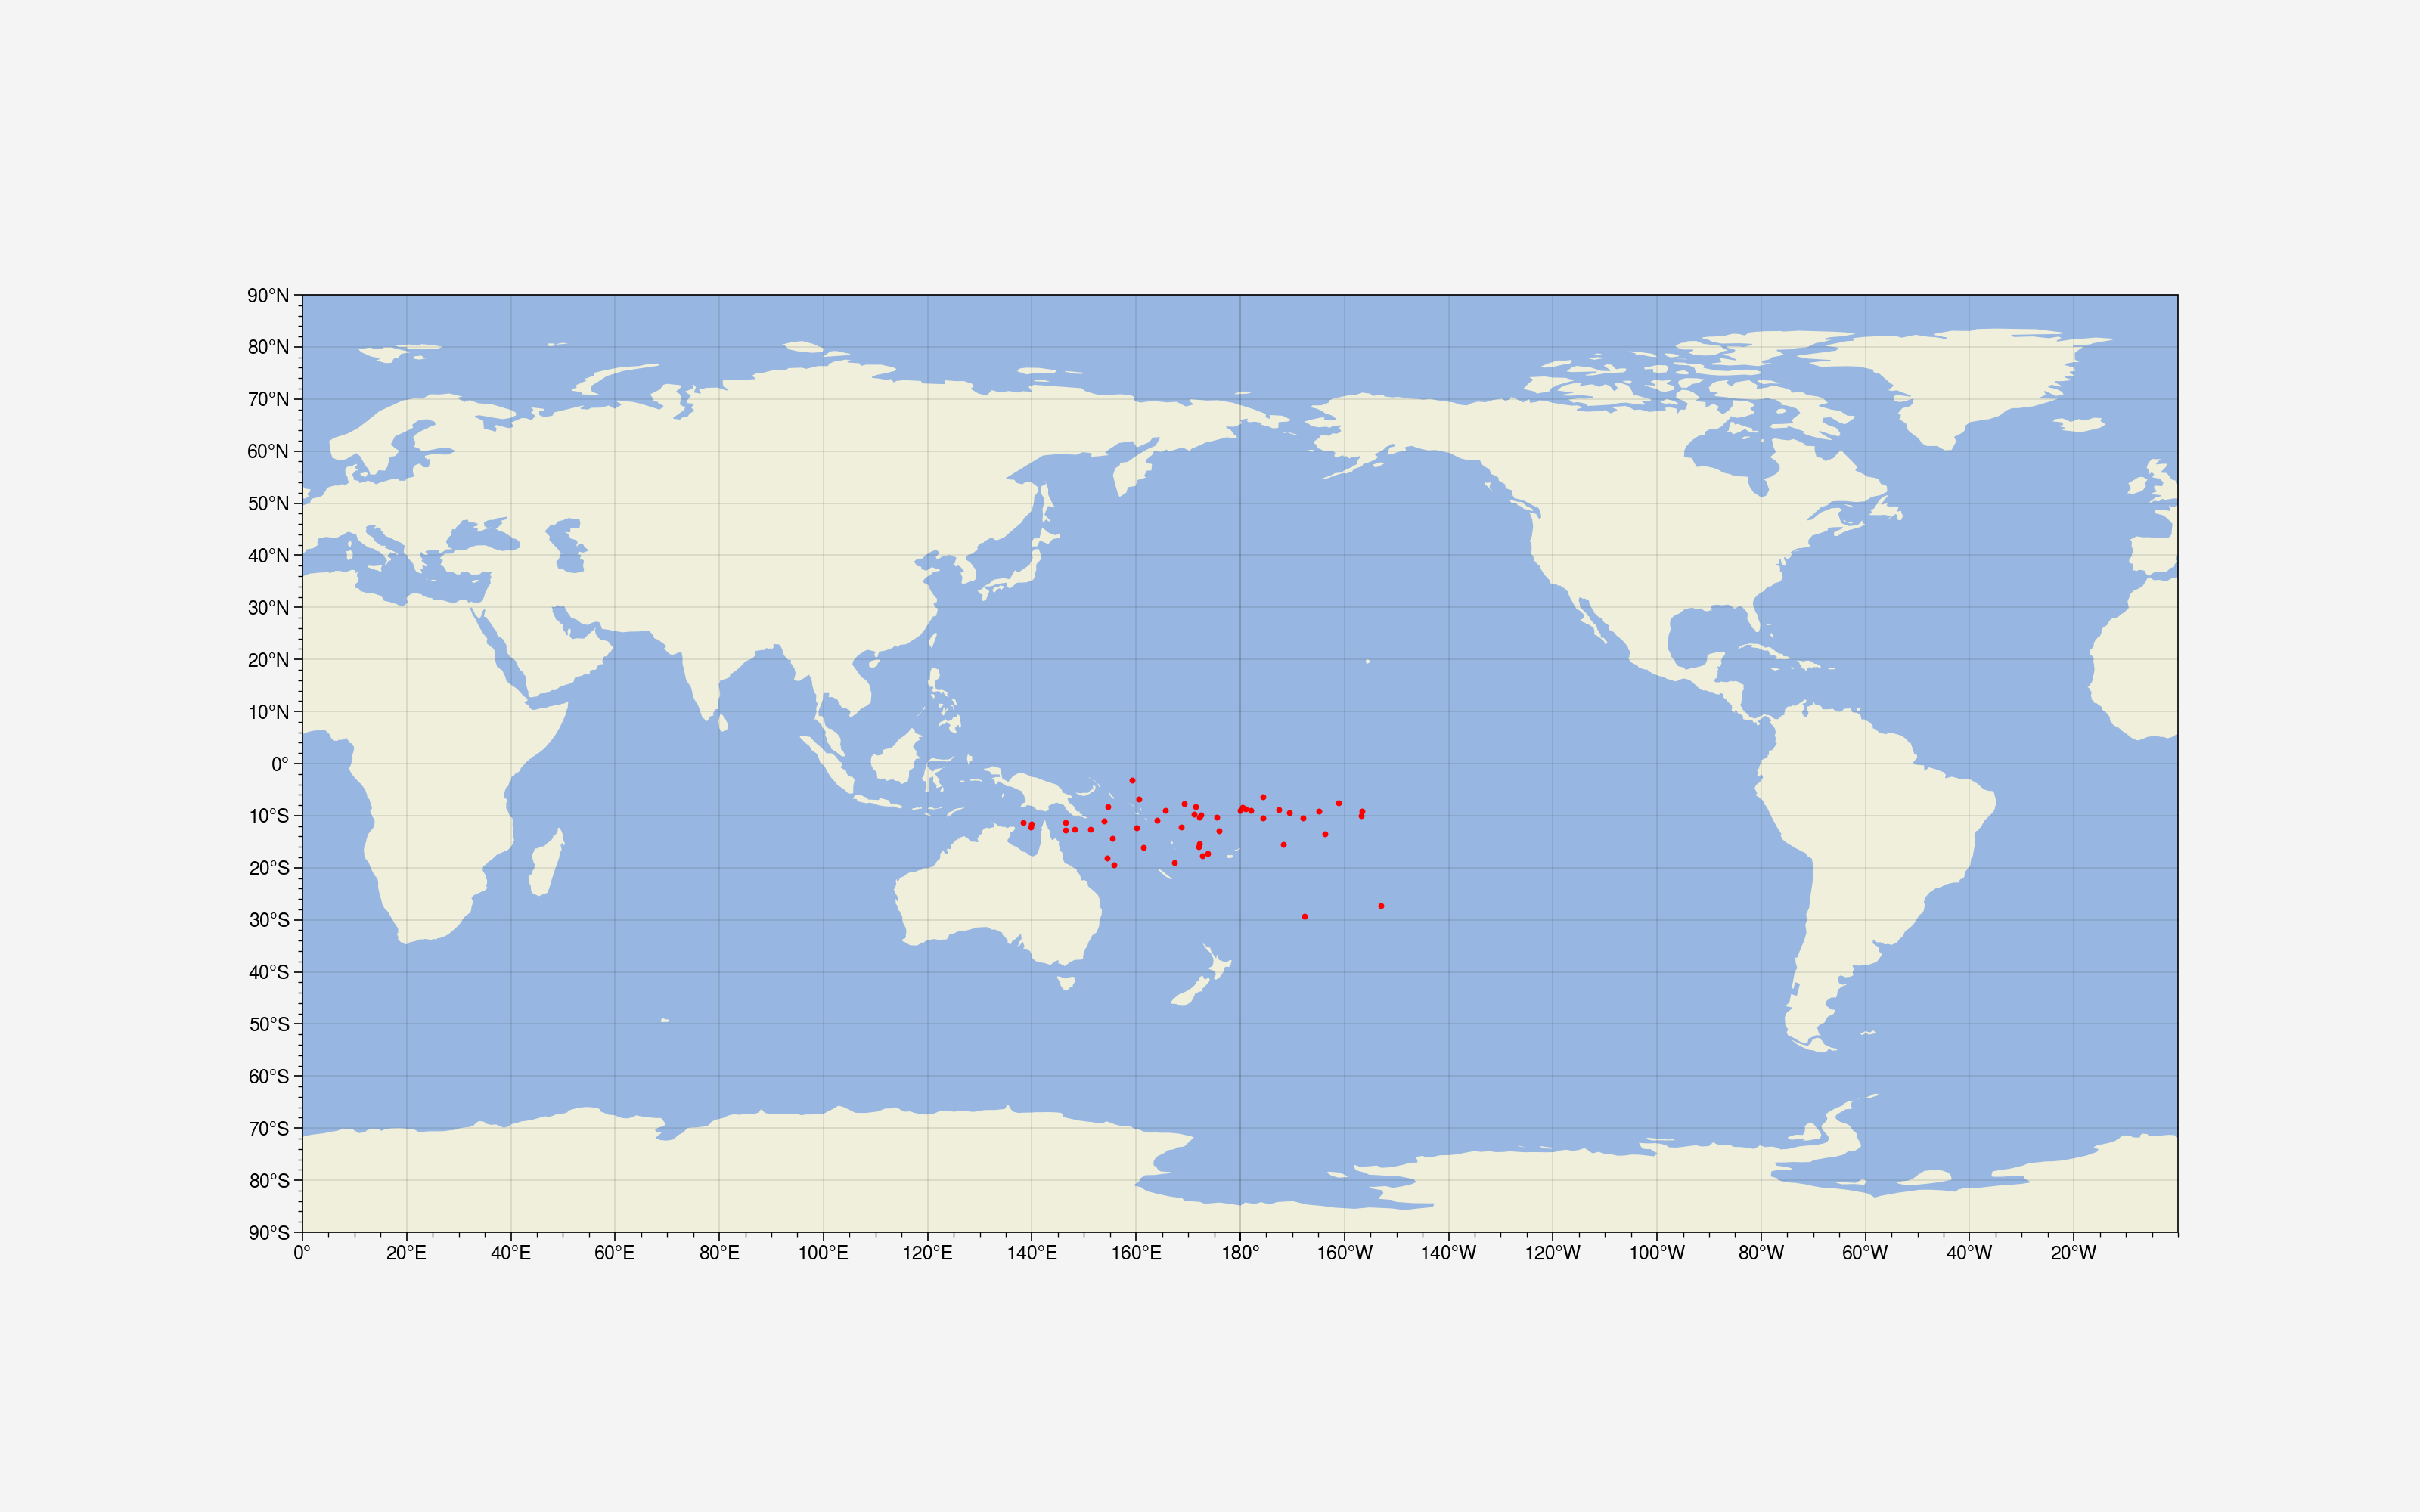

<Figure size 2000x1000 with 0 Axes>

In [158]:
df_sp = df[df['BASIN'] == 'SP']

# 厄尔尼诺风速最大值最小值经纬度列表
df_wind_speed_min, df_wind_speed_max= lat_and_lon_usa_wind_speed(df_sp, einino)

# 厄尔尼诺最大风速的最小经度 最小温度 
low_point_lon, low_point_lat, scale_lon, scale_lat = lon_lat_min(df_sp, df_wind_speed_max, year_list = einino)

map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(16, 10),
    subplot_kw={'projection': map_proj}
)

ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks(np.linspace(-180, 180, 19), crs=tick_proj)
ax.set_yticks(np.linspace(-90, 90, 19), crs=tick_proj)

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())


ax.scatter(df_aptitude_einino_min['LON'], df_aptitude_einino_min['LAT'],
        s=5, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# ax.scatter(df_aptitude_einino_max['LON'], df_aptitude_einino_max['LAT'],
#         s=10, c = 'b', marker = '*', 
#         transform=ccrs.PlateCarree())


# ax.coastlines()
# ax.set_global()
# NA= patches.Rectangle((low_point_lon, low_point_lat),scale_lon,scale_lat,
#                       linewidth=1,linestyle='-' ,
#                       zorder=4,edgecolor='black',facecolor='none', transform=ccrs.PlateCarree())

# ax.add_patch(NA) 


map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=[20, 10])

纬度最小值为11.00，最大值为19.40
经度最小值为-134.10，最大值为-102.60
纬度最大差值为8.40，经度最大差值为31.50


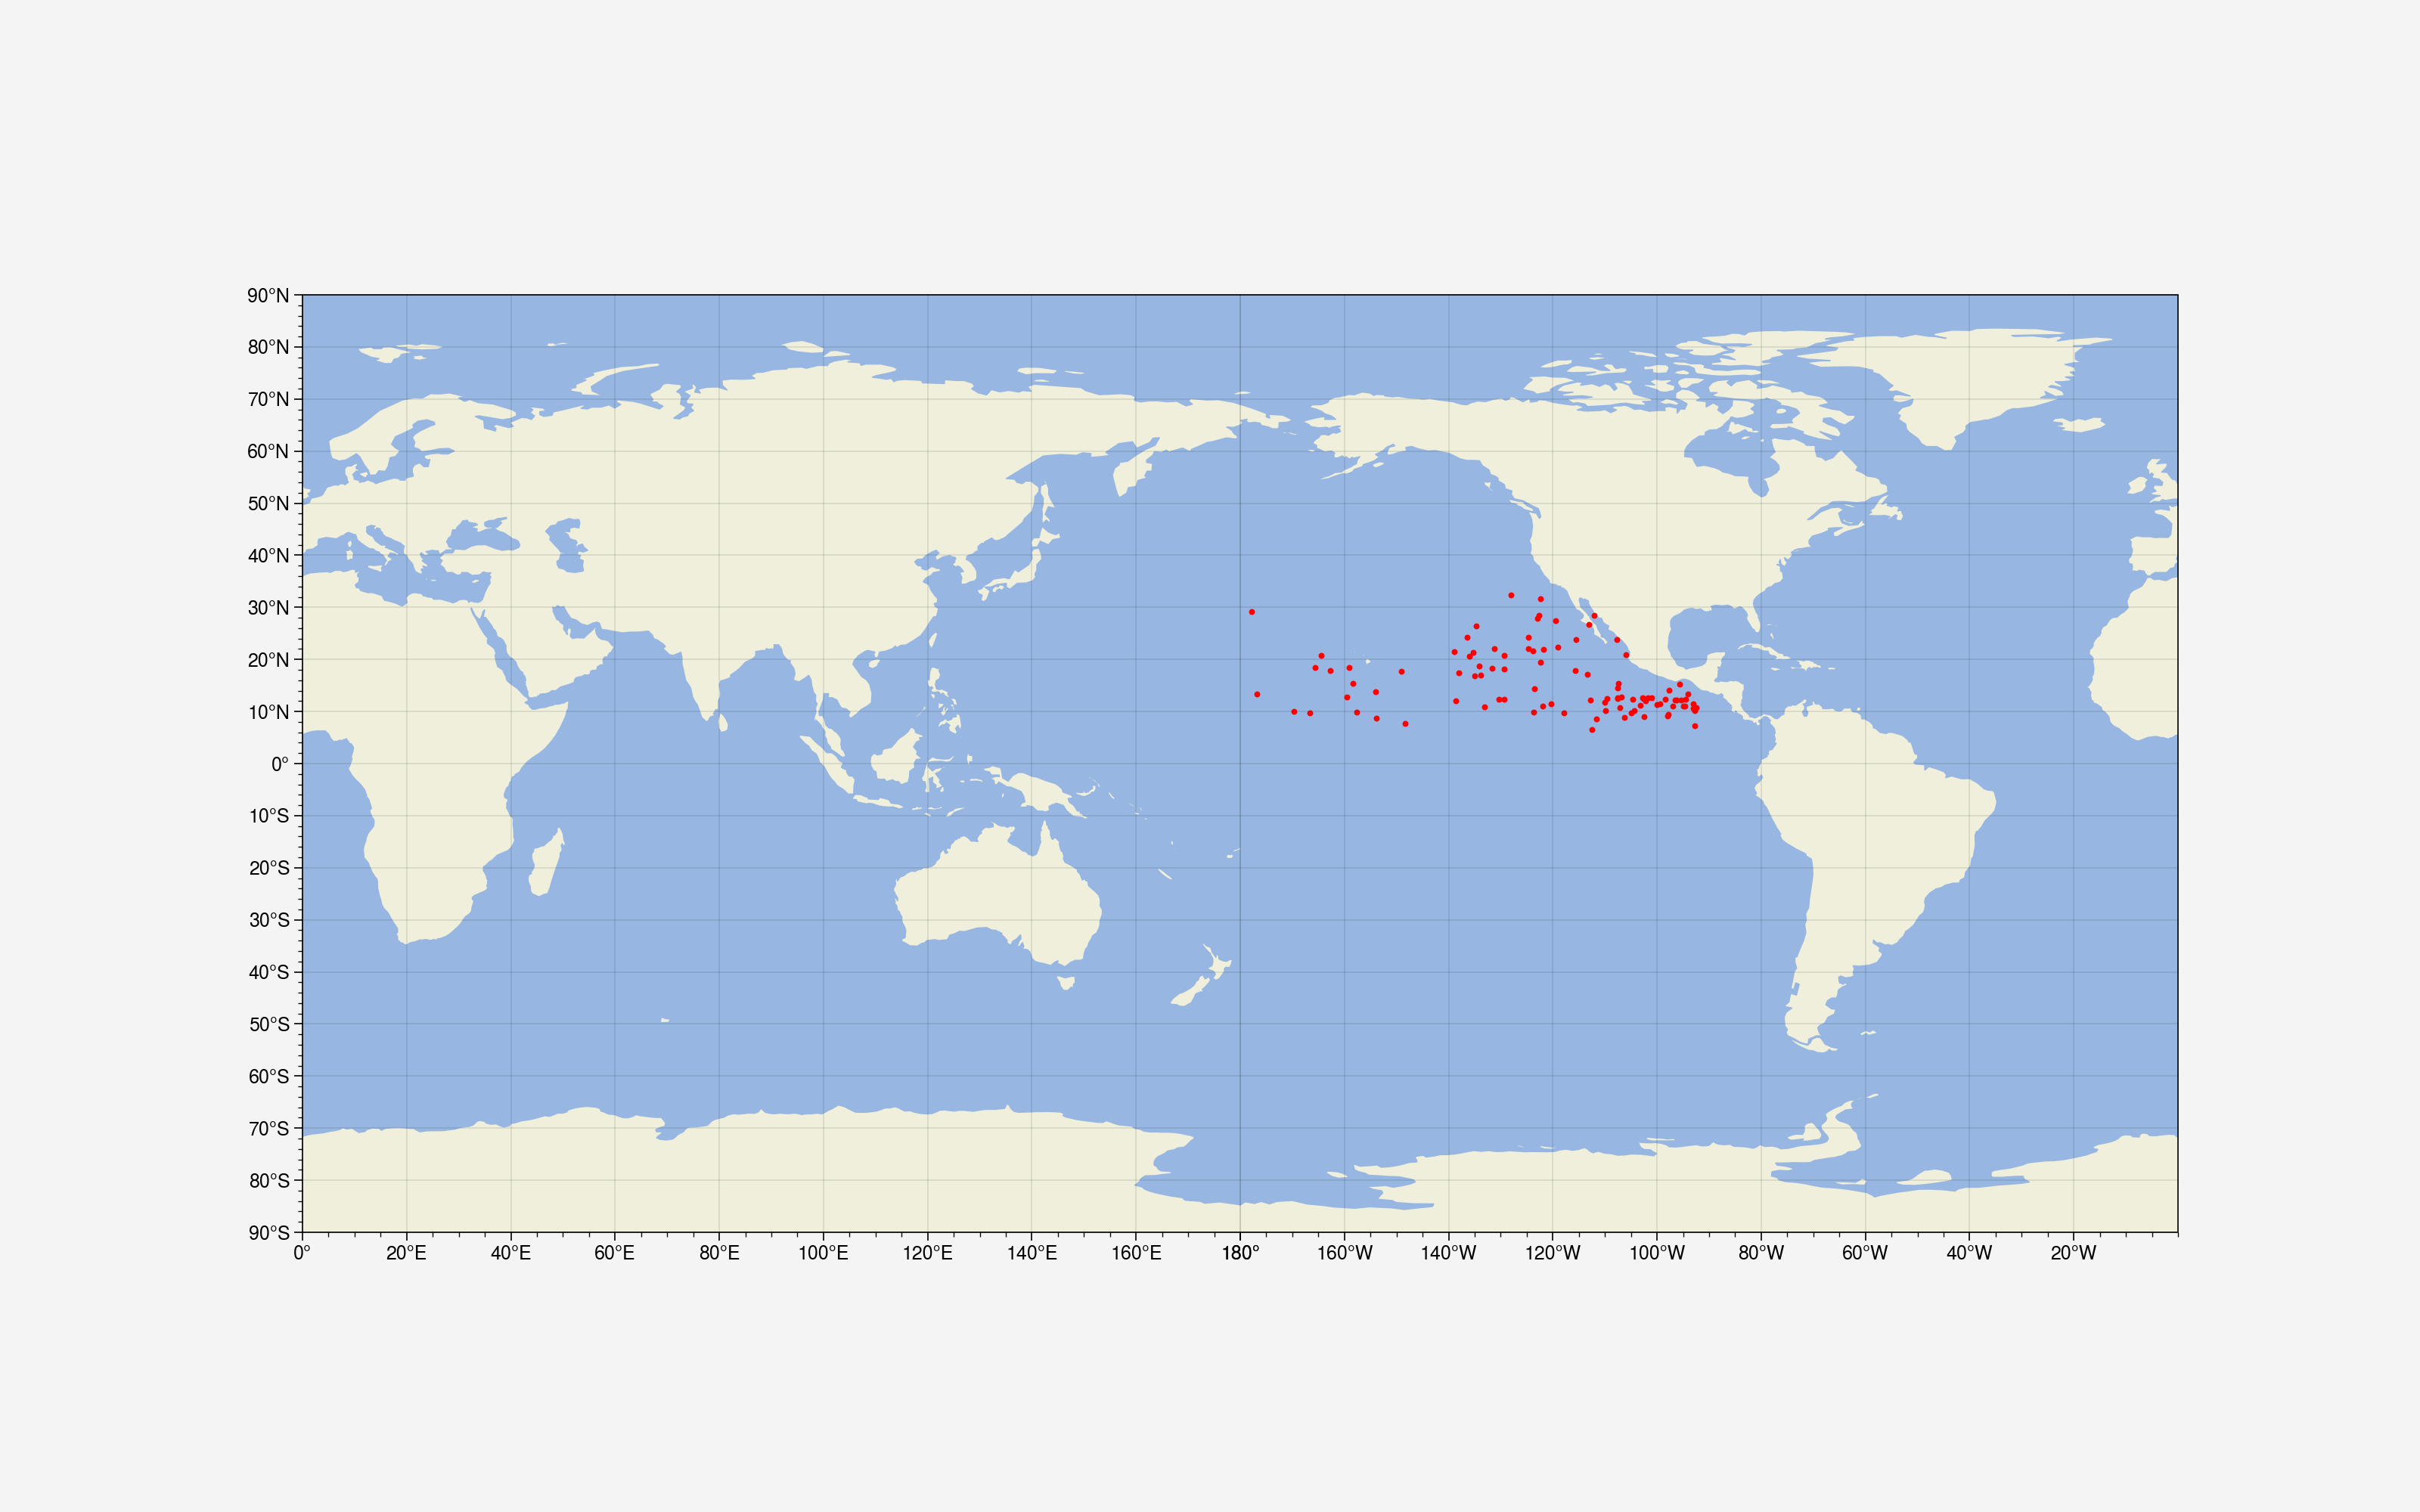

<Figure size 2000x1000 with 0 Axes>

In [209]:

df_ep = df[df['BASIN'] == 'EP']
einino = [1982,1986,1987,1991,1994,1997,2002,2004,2009,2015]

# einino = [2002]

df_aptitude_einino_min, df_aptitude_einino_max= aptitude(df_ep, einino)

df_lat = df_aptitude_einino_min.sort_values(by = ['LAT']).reset_index()

# LON列里面的值大于180的value，用value-360代替
df_aptitude_einino_min['LON'] = df_aptitude_einino_min['LON'].mask(df_aptitude_einino_min['LON'] > 180, 
                                                                   (df_aptitude_einino_min['LON'] - 360))

df_lon = df_aptitude_einino_min.sort_values(by = ['LON']).reset_index()

"""
找出（25%, 75%)纬度范围(low_point_lat, up_point_lat)
"""
low_line_lat = int(df_lat.shape[0] / 4)
up_line_lat = int(df_lat.shape[0] * 3 / 4)
low_point_lat = df_lat.iloc[low_line_lat-1]['LAT']
up_point_lat = df_lat.iloc[up_line_lat]['LAT']

# low_point_lat = df_lat["LAT"][0]
# up_point_lat = df_lat['LAT'][df_lat.shape[0] - 1]

print("纬度最小值为%.2f，最大值为%.2f"%(low_point_lat, up_point_lat))

"""
找出（25%, 75%)经度范围(low_point_lon, up_point_lon)
"""
low_line_lon = int(df_lon.shape[0] / 4)
up_line_lon = int(df_lon.shape[0] * 3 / 4)
low_point_lon = df_lon.iloc[low_line_lon-1]['LON']
up_point_lon = df_lon.iloc[up_line_lon]['LON']

# low_point_lon = df_lon["LON"][0]
# up_point_lon = df_lon["LON"][df_lon.shape[0] - 1]

# 判断新的纬度值是不是最小值
# if up_point_lon > 180:
#     tmp = up_point_lon - 360
#     if low_point_lon > tmp:
#         low_point_lon = up_point_lon - 360
        
#     up_point_lon = df_lon["LON"][df_lon.shape[0] - 1 - 1]

print("经度最小值为%.2f，最大值为%.2f"%(low_point_lon, up_point_lon))

scale_lat = up_point_lat - low_point_lat

scale_lon = up_point_lon - low_point_lon

print("纬度最大差值为%.2f，经度最大差值为%.2f"%(scale_lat, scale_lon))


map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(16, 10),
    subplot_kw={'projection': map_proj}
)

ax.set_global()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_xticks(np.linspace(-180, 180, 19), crs=tick_proj)
ax.set_yticks(np.linspace(-90, 90, 19), crs=tick_proj)

ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())


ax.scatter(df_aptitude_einino_min['LON'], df_aptitude_einino_min['LAT'],
        s=5, c = 'r', marker = 'o', 
        transform=ccrs.PlateCarree())

# ax.scatter(df_aptitude_einino_max['LON'], df_aptitude_einino_max['LAT'],
#         s=10, c = 'b', marker = '*', 
#         transform=ccrs.PlateCarree())


# ax.coastlines()
# ax.set_global()
# NA= patches.Rectangle((low_point_lon, low_point_lat),scale_lon,scale_lat,
#                       linewidth=1,linestyle='-' ,
#                       zorder=4,edgecolor='black',facecolor='none', transform=ccrs.PlateCarree())

# ax.add_patch(NA) 


map_proj = ccrs.PlateCarree(central_longitude=180)
tick_proj = ccrs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=[20, 10])


In [19]:
df_lat['LAT'][df_lat.shape[0] - 1]

32.4

In [20]:
df_lat

,index,SEASON,NUMBER,LAT,LON,USA_WIND
0,86,2015,51,6.50,-112.5,20.0
1,80,2009,82,7.20,-92.8,20.0
2,88,2015,63,7.70,211.6,20.0
3,52,1997,49,8.60,-111.7,25.0
4,67,2002,85,8.70,206.2,20.0
...,...,...,...,...,...,...
93,8,1982,80,28.40,-122.6,25.0
94,73,2004,72,28.50,-112.0,20.0
95,33,1991,40,29.13,182.2,20.0
96,85,2015,45,31.70,-122.3,20.0


In [23]:
df_lon.head()

,index,SEASON,NUMBER,LAT,LON,USA_WIND
0,89,2015,65,13.40,-176.80,20.0
1,11,1982,100,9.66,-166.60,40.0
2,14,1986,64,18.49,-165.67,27.0
3,42,1994,47,20.75,-164.53,25.0
4,5,1982,58,17.80,-162.66,27.0
...,...,...,...,...,...,...
93,64,2002,54,9.80,202.40,15.0
94,67,2002,85,8.70,206.20,20.0
95,88,2015,63,7.70,211.60,20.0
96,44,1994,59,11.40,239.60,25.0


In [24]:
df['LON'].max()

266.9

In [25]:
df['LON'].min()

-179.75

In [30]:
df['LON'].max() - df['LON'].min()

446.65

In [27]:
df['LAT'].max()

65.47

In [28]:
df['LAT'].min()

-68.01

In [29]:
df['LAT'].max() - df['LAT'].min()

133.48000000000002